Задача: Классификация текста

1) EDA - анализа данных.
  - показать разные статистики для ваших данных
  - визуализировать данные
  - очистить от мусора
  - новые фичи, которые вы придумаете (попробовать повыделять разные фичи, которые мы в теории прошли на паре)
  - какие-нибудь интересные метода, которые вы придумаете

2) embeddings:
  - one hot encoding
  - word2vec обученную / самим обучить
  - fasttext обученную / самим обучить
  - tf-idf
  - что сами придумаете

3) ML-algorithms:
  - 2 простых алгоритма (SVM, LogReg, NaiveBayes или другие)
  - кросс-валидация
  - GridSearch для подбора гиперпараметров
  
4) Нейронные сети:
  - Попробовать любую архитектуру из тех, что прошли на паре. (полносвязанная сетка, сверточная сетка или рекурентная)
  - перебор гиперпараметров, слоев и тд.


In [ ]:
import random
random.seed(10)

In [ ]:
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install nltk gensim pyLDAvis seaborn wordcloud pymorphy2
import re
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

import gensim
import gensim.corpora as corpora
import pyLDAvis.gensim
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import LdaModel
import numpy as np
import gensim
from gensim.models import Word2Vec
import numpy as np
from collections import defaultdict

Looking in indexes: https://nexus.services.mts.ru/repository/pip/simple


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/adminus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/adminus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
!wget -O ecommerceDataset.csv https://www.dropbox.com/scl/fi/t9i2bfnp2scesd4lnjkxg/ecommerceDataset.csv?rlkey=yo5g8d0zgj0ppsxiy2010yw3i&st=etdjzdxw&dl=0

zsh:1: parse error near `&'


# EDA


О чем датасет: текст рекламы различных предметров

Классификация на: что это за предмет, например, электроника, одежда, домашняя утварь или книги.

Грузим датасет, с учетом двух колонок: 'target', 'source_text'

In [ ]:
df = pd.read_csv('ecommerceDataset.csv',sep=',', header=None, names=['target', 'source_text'])
df = df.sample(frac=0.25, replace=True, random_state=42)
df.head()

target  \
15795               Household   
860                 Household   
38158  Clothing & Accessories   
44732             Electronics   
11284               Household   

                                             source_text  
15795  BLACK+DECKER VH-801 800-Watt Handheld Vacuum C...  
860    IRA Rattan Swing Chair With Patterned Heart Ra...  
38158  Soulemo Women's Pure Cotton Feeding Nighty/Mat...  
44732  Redmi 6A (Black, 2GBRAM, 16GB Storage) Size na...  
11284  ANMSALES Sunsun JY-02 | Surface Protein Skimme...

Инфомация ниже уже дает нам понимание, что у нас нет пропущенных обьектов, и мы видим что обе колонки типа обьекты

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12606 entries, 15795 to 37030
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   target       12606 non-null  object
 1   source_text  12606 non-null  object
dtypes: object(2)
memory usage: 295.5+ KB


На всякий случай смотрим пропущенные значения и дубликаты:

In [ ]:
# Проверка на наличие пропущенных значений
missing_values = df.isnull().sum()

# Проверка на наличие дубликатов
duplicates = df.duplicated().sum()

print("Пропущенные значения:")
print(missing_values)

print("Количество дубликатов: ", duplicates)

Пропущенные значения:
target         0
source_text    0
dtype: int64
Количество дубликатов:  3141


Так как пропущенных значений нет, а дубликаты есть - убираем только все дубликаты.

In [ ]:
df = df.drop_duplicates(keep='last')

Теперь вот небольшая функция очистки, она ключает в себя:
* удаление различных символов, которые могли появиться при парсинге
* удаление пунктуации
* удаление стоп слов
* вариативную часть - приведение к lower case

In [ ]:
def clean_text(text, lower = False):
    if lower:
        text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'<b>', '', text) # Ненужные символы
    text = re.sub(r'</b>', '', text) # Ненужные символы
    text = re.sub(r'<br/>', '', text) # Ненужные символы
    text = re.sub(r'http\S+', '', text)  # Удаление ссылок
    text = re.sub(r'www\S+', '', text)   # Удаление ссылок
    text = re.sub(r'@\w+', '', text)     # Удаление упоминаний
    text = re.sub(r'[^\w\s]', '', text)  # Удаление пунктуации и специальных символов

    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words]

    return ' '.join(words)

stop_words = set(stopwords.words('english'))

# Применяем функцию очистки к столбцу 'source_text'
df['cleaned_text'] = df['source_text'].apply(clean_text)

df['cleaned_text_lower'] = df['source_text'].apply(lambda x: clean_text(x, lower=True))

# Показываем первые строки для проверки
df[['source_text', 'cleaned_text', 'cleaned_text_lower']].head()

source_text  \
15795  BLACK+DECKER VH-801 800-Watt Handheld Vacuum C...   
44732  Redmi 6A (Black, 2GBRAM, 16GB Storage) Size na...   
6265   Hot Wheels Track Builder Custom Turn Kicker St...   
21962                    Investment Banking for Dummies    
47191  Saihan Hot Shoe Protector Cover Cap Hot Shoe M...   

                                            cleaned_text  \
15795  BLACKDECKER VH801 800Watt Handheld Vacuum Clea...   
44732  Redmi 6A Black 2GBRAM 16GB Storage Size name16...   
6265   Hot Wheels Track Builder Custom Turn Kicker St...   
21962                         Investment Banking Dummies   
47191  Saihan Hot Shoe Protector Cover Cap Hot Shoe M...   

                                      cleaned_text_lower  
15795  blackdecker vh801 800watt handheld vacuum clea...  
44732  redmi 6a black 2gbram 16gb storage size name16...  
6265   hot wheels track builder custom turn kicker st...  
21962                         investment banking dummies  
47191  saihan hot shoe protector cover cap hot shoe m...

Почему мы оставили без ловеркейс и с? Потому что бывают случаи, когда возможно классификация может зафисеть в том числе и от того заглавные это буквы или нет, поэтому пока оставим. Потом покажем, что наша гипотеза себя не оправдала.

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

def lemmatize_words(words):
    words = nltk.word_tokenize(words)

    lemm_words = [morph.parse(word)[0].normal_form for word in words]
    return ' '.join(lemm_words)

df["lemmatization"] = df['cleaned_text_lower'].apply(lambda x: lemmatize_words(x))

/home/adminus/.anya_venv/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/home/adminus/.anya_venv/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/home/adminus/.anya_venv/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/home/adminus/.anya_venv/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspe

И так, помимо гипотезы заглавных и lowercase стиля, добавим гипотезы влияния лемматизации и стемминга, все по стандарту.

In [ ]:
from nltk.stem.snowball import SnowballStemmer

# Инициализируем стеммер для русского языка
stemmer = SnowballStemmer(language="english")

def stemm_words(words):
    words = nltk.word_tokenize(words)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

df["stemming"] = df['cleaned_text_lower'].apply(lambda x: stemm_words(x))

Получается что-то такое:

In [ ]:
df

target  \
15795               Household   
44732             Electronics   
6265                Household   
21962                   Books   
47191             Electronics   
...                       ...   
16661               Household   
31555  Clothing & Accessories   
28690                   Books   
32833  Clothing & Accessories   
37030  Clothing & Accessories   

                                             source_text  \
15795  BLACK+DECKER VH-801 800-Watt Handheld Vacuum C...   
44732  Redmi 6A (Black, 2GBRAM, 16GB Storage) Size na...   
6265   Hot Wheels Track Builder Custom Turn Kicker St...   
21962                    Investment Banking for Dummies    
47191  Saihan Hot Shoe Protector Cover Cap Hot Shoe M...   
...                                                  ...   
16661  DMT™ Toran PVC nsulated Wire 1.5 SQ/MM Single ...   
31555  VIMAL Winter King Blended Thermal Top & Pyjama...   
28690  Modern Dental Assisting Review Become an indis...   
32833  Naughty Ninos Cotton Cut-Out Dress Your little...   
37030  Selfcare Women's Cotton Tummy Controller Hipst...   

                                            cleaned_text  \
15795  BLACKDECKER VH801 800Watt Handheld Vacuum Clea...   
44732  Redmi 6A Black 2GBRAM 16GB Storage Size name16...   
6265   Hot Wheels Track Builder Custom Turn Kicker St...   
21962                         Investment Banking Dummies   
47191  Saihan Hot Shoe Protector Cover Cap Hot Shoe M...   
...                                                  ...   
16661  DMT Toran PVC nsulated Wire 15 SQMM Single Cor...   
31555  VIMAL Winter King Blended Thermal Top Pyjama S...   
28690  Modern Dental Assisting Review Become indispen...   
32833  Naughty Ninos Cotton CutOut Dress Your little ...   
37030  Selfcare Womens Cotton Tummy Controller Hipste...   

                                      cleaned_text_lower  \
15795  blackdecker vh801 800watt handheld vacuum clea...   
44732  redmi 6a black 2gbram 16gb storage size name16...   
6265   hot wheels track builder custom turn kicker st...   
21962                         investment banking dummies   
47191  saihan hot shoe protector cover cap hot shoe m...   
...                                                  ...   
16661  dmt toran pvc nsulated wire 15 sqmm single cor...   
31555  vimal winter king blended thermal top pyjama s...   
28690  modern dental assisting review become indispen...   
32833  naughty ninos cotton cutout dress little angel...   
37030  selfcare womens cotton tummy controller hipste...   

                                           lemmatization  \
15795  blackdecker vh801 800watt handheld vacuum clea...   
44732  redmi 6a black 2gbram 16gb storage size name16...   
6265   hot wheels track builder custom turn kicker st...   
21962                         investment banking dummies   
47191  saihan hot shoe protector cover cap hot shoe m...   
...                                                  ...   
16661  dmt toran pvc nsulated wire 15 sqmm single cor...   
31555  vimal winter king blended thermal top pyjama s...   
28690  modern dental assisting review become indispen...   
32833  naughty ninos cotton cutout dress little angel...   
37030  selfcare womens cotton tummy controller hipste...   

                                                stemming  
15795  blackdeck vh801 800watt handheld vacuum cleane...  
44732  redmi 6a black 2gbram 16gb storag size name16 ...  
6265   hot wheel track builder custom turn kicker sty...  
21962                                  invest bank dummi  
47191  saihan hot shoe protector cover cap hot shoe m...  
...                                                  ...  
16661  dmt toran pvc nsulat wire 15 sqmm singl core f...  
31555  vimal winter king blend thermal top pyjama set...  
28690  modern dental assist review becom indispens as...  
32833  naughti nino cotton cutout dress littl angel b...  
37030  selfcar women cotton tummi control hipster pan...  

[9465 rows x 6 columns]

In [ ]:
ways_for_processing = ["cleaned_text", "cleaned_text_lower", "stemming", "lemmatization"]

## Визуализация статистик данных

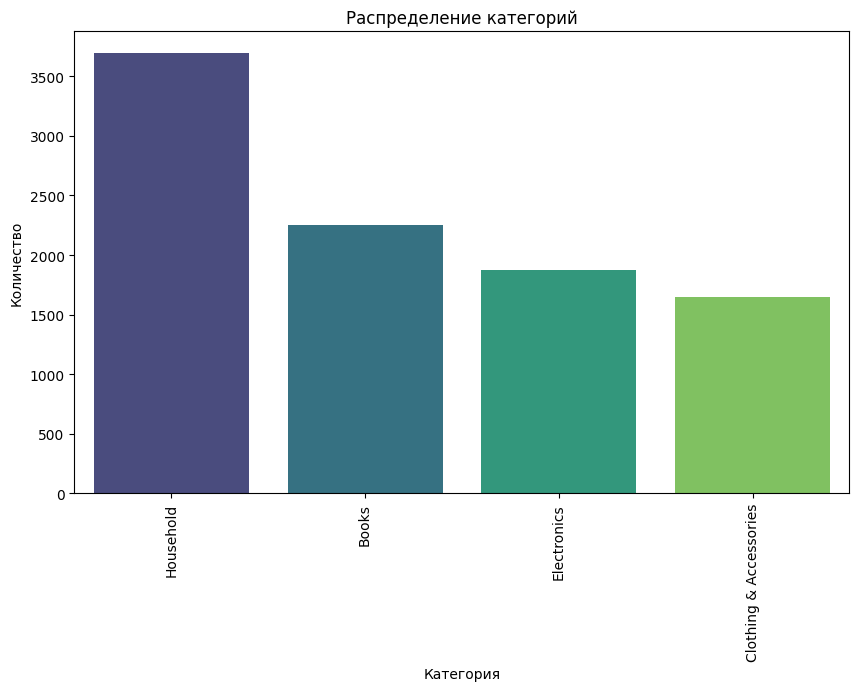

In [ ]:
# Подсчитываем количество записей для каждой уникальной категории
target_counts = df['target'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=target_counts.index, y=target_counts.values, palette='viridis')
plt.title('Распределение категорий')
plt.ylabel('Количество')
plt.xlabel('Категория')
plt.xticks(rotation=90)
plt.show()

Мы видим, что распределение по классам у нас не равномерное - household почти в два раза чаще встречается, чем класс про одежду. Наша задача здесь, получается - научится несмотря на это все равно хорошо предсказывать класс с одеждой.

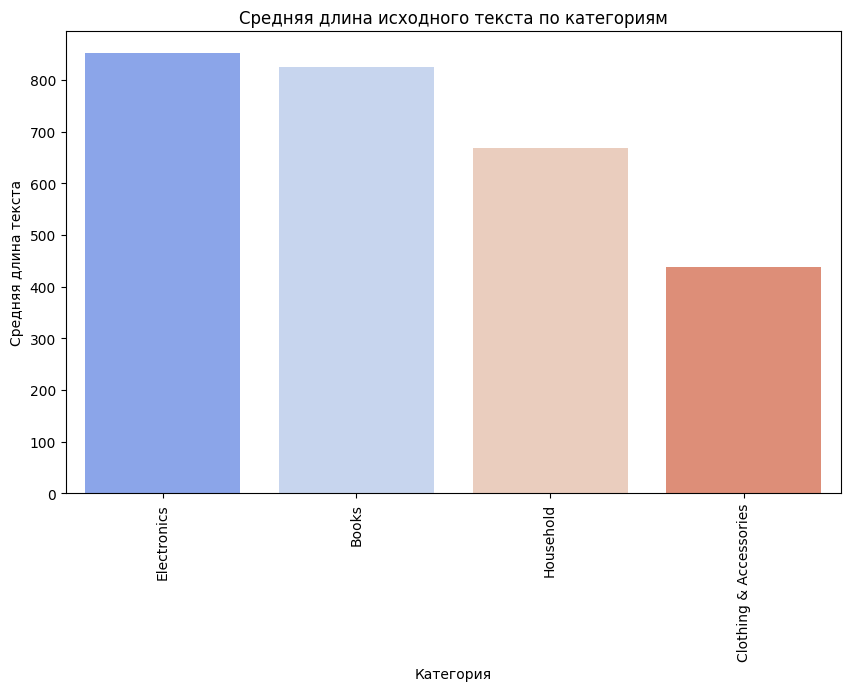

In [ ]:
# Вычисляем длину текста в каждой строке 'source_text'
df['text_length'] = df['source_text'].apply(len)

# Группируем по 'target' и вычисляем среднюю длину текста
avg_text_length = df.groupby('target')['text_length'].mean().sort_values(ascending=False)

# Строим график средней длины текста для каждой категории
plt.figure(figsize=(10,6))
sns.barplot(x=avg_text_length.index, y=avg_text_length.values, palette='coolwarm')
plt.title('Средняя длина исходного текста по категориям')
plt.ylabel('Средняя длина текста')
plt.xlabel('Категория')
plt.xticks(rotation=90)
plt.show()


Если смотреть на исходную длину текста, то можно заметить, что в описании электроники, так же как и у книг - больше всего слов. Возможно это потому, что у электроники - огромное количество характеристик, а у книг - детали сюжета. Поэтому чтобы разрекламировать их нужно больше деталей. У товаров для дома меньше описание и меньше всего у одежды. Это может быть потому, что деталей у одежды описательных характеристик - не так уж и много, чтобы их прорекламировать, гораздо больше решает визуал.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Функция для получения самых частых слов в тексте
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

target_groups = df.groupby('target')

cnt=5

for ethno, group in target_groups:
    print(f"\nНаиболее частые слова для {ethno}:")
    top_words = get_top_n_words(group['cleaned_text_lower'], 10)
    print(top_words)
    cnt-=1
    if cnt < 0:
        break


Наиболее частые слова для Books:
[('book', 2128), ('author', 1733), ('new', 910), ('books', 896), ('one', 770), ('review', 667), ('also', 605), ('university', 577), ('students', 513), ('world', 509)]

Наиболее частые слова для Clothing & Accessories:
[('cotton', 1061), ('wear', 684), ('size', 583), ('womens', 578), ('made', 532), ('fit', 529), ('fabric', 528), ('look', 501), ('set', 451), ('women', 441)]

Наиболее частые слова для Electronics:
[('usb', 1111), ('camera', 826), ('power', 785), ('black', 731), ('wireless', 723), ('bluetooth', 712), ('cable', 672), ('audio', 616), ('sound', 590), ('card', 561)]

Наиболее частые слова для Household:
[('set', 1409), ('use', 1394), ('home', 1351), ('easy', 1347), ('steel', 1127), ('quality', 1073), ('made', 1065), ('product', 1002), ('water', 971), ('design', 953)]


Посмотрев на частоту слов после их очистки, и что важно приведения к нижнему регистру, мы можем заметить, что самые частотные слова очень хорошо отображают класс, к которому относятся. Например, для домашней утвари очевидно выглядывает слова home, made, product, в то время как для книг это первое же слово book, для одежды cotton, для электроники различные технические оснащения.

Почему тут важно было привести к нижнему регистру? Потому что иначе остаются всякие слова пустышки типа the, it и прочее, которые не удалились при очистке стоп слов. В нижнем регистре все идеально!

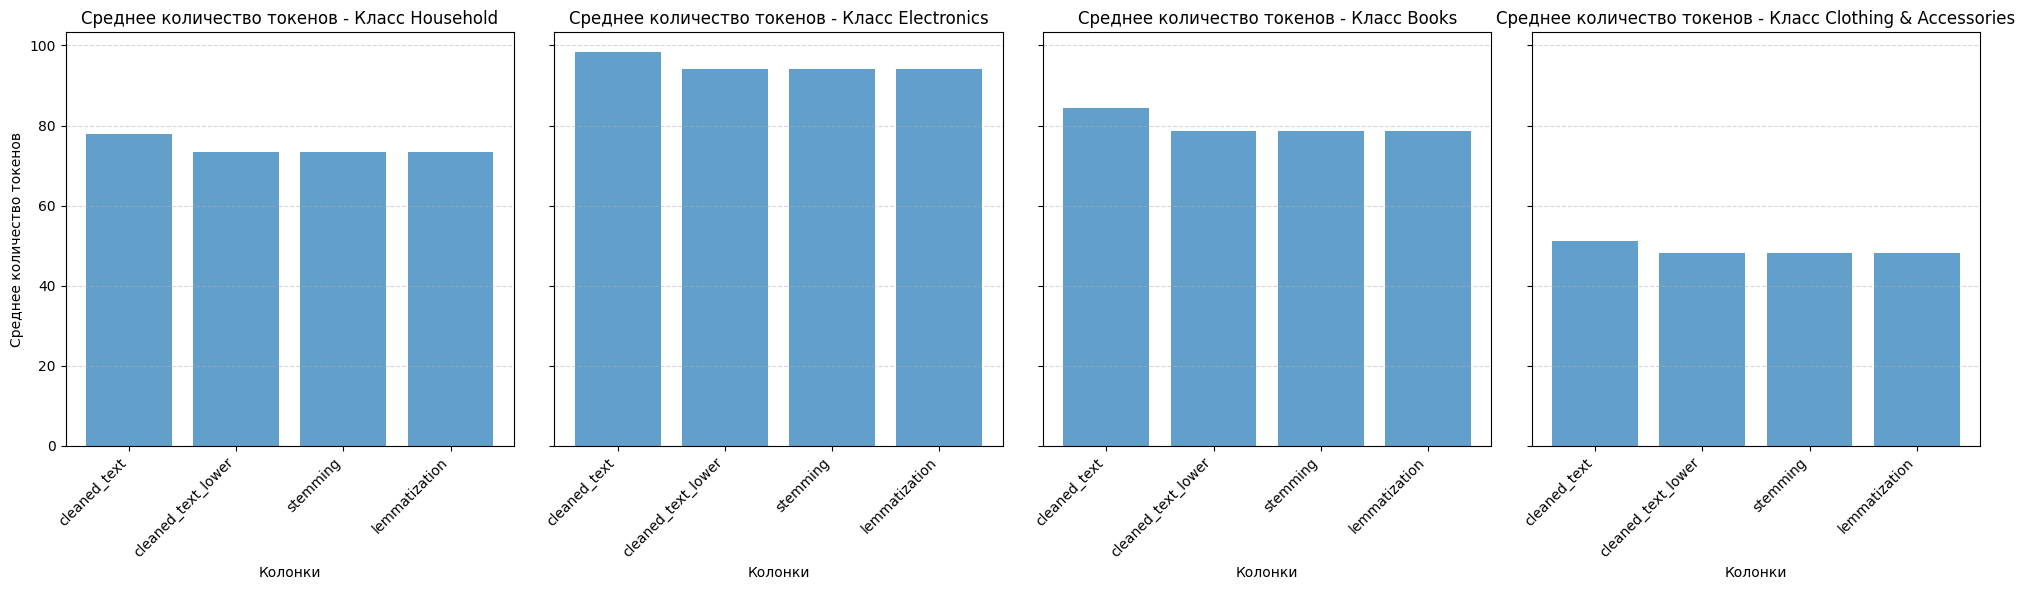

In [ ]:

def count_tokens(text):
    return len(text.split())

# Подготовка данных для визуализации распределения
df_token_counts = df.copy()
for column in ways_for_processing:
    df_token_counts[f"{column}_tokens"] = df_token_counts[column].apply(count_tokens)

classes = df['target'].unique()

# Подсчет среднего количества токенов по классам для каждой колонки
average_tokens_per_class = {cls: {} for cls in classes}

for cls in classes:
    # Фильтрация данных по классу
    class_data = df_token_counts[df_token_counts['target'] == cls]

    # Вычисление среднего количества токенов для каждой из колонок
    for column in ways_for_processing:
        average_tokens = class_data[f"{column}_tokens"].mean()
        average_tokens_per_class[cls][column] = average_tokens

fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True)

# Визуализация для каждого класса
for idx, cls in enumerate(classes):
    # Данные для столбчатой диаграммы
    columns = list(average_tokens_per_class[cls].keys())
    averages = list(average_tokens_per_class[cls].values())

    # Построение столбчатой диаграммы
    axes[idx].bar(columns, averages, alpha=0.7)
    axes[idx].set_title(f"Среднее количество токенов - Класс {cls}")
    axes[idx].set_xlabel("Колонки")
    axes[idx].set_xticklabels(columns, rotation=45, ha='right')
    if idx == 0:
        axes[idx].set_ylabel("Среднее количество токенов")
    axes[idx].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


Посмотрим на частотность в разрезе классов, мы снова замечаем, что у электроники больше всего в среднем токенов, а у одежды меньше всего. Интересный момент тут, что мы чуть-чуть снижаем количество токенов при приведении в нижний регистр. Лемматизация и стемминг сделаны на нижнем регистре, поэтому для них количество слов одинаковое.

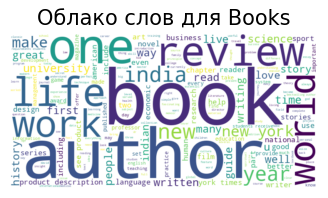

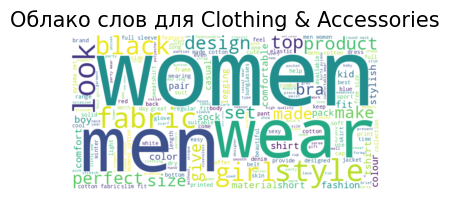

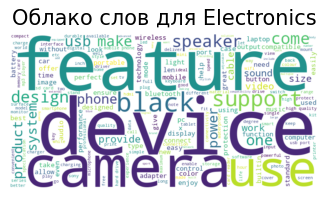

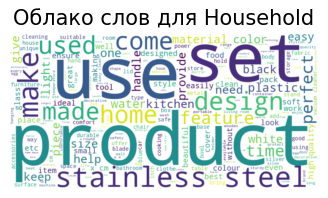

In [ ]:
# Импортируем модуль для создания облака слов
from wordcloud import WordCloud

# Функция для построения облака слов
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(5, 2))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

# Генерируем облако слов для каждой группы
cnt = 5
for ethno, group in target_groups:
    plot_wordcloud(group['cleaned_text_lower'], f'Облако слов для {ethno}')
    cnt-=1
    if cnt < 0:
      break

Как мы уже писали, уже по частотным словам можно сильно определить класс к которому текст относится. У нас есть четкое разделение и отсутствуют пересекающиеся слова.

## Анализ LDA


In [ ]:
# Токенизация данных
X_tokenized = [text.split() for text in df['cleaned_text']]

# Шаг 1: Подготовка данных для LDA
# Создаем словарь и корпус на основе токенизированных данных
id2word = corpora.Dictionary(X_tokenized)
corpus = [id2word.doc2bow(text) for text in X_tokenized]

# Обучение LDA модели
lda_gensim = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=4,
    passes=10,
    random_state=42
)

# Функция для получения топовых слов из тем
def get_top_words_gensim(model, num_words):
    top_words = []
    for i in range(model.num_topics):
        top_words.append([word for word, prob in model.show_topic(i, topn=num_words)])
    return top_words

n_top_words = 30
top_words = get_top_words_gensim(lda_gensim, n_top_words)

# Печать топовых слов для каждой темы
for i, topic in enumerate(top_words):
    print(f"Topic {i+1}: {', '.join(topic)}")

# Шаг 2: Преобразование тем в признаки для классификации
def get_topic_features(model, corpus):
    return np.array([[topic_prob for _, topic_prob in model.get_document_topics(doc, minimum_probability=0)] for doc in corpus])

# Шаг 4: Визуализация результатов LDA
vis_data = pyLDAvis.gensim.prepare(lda_gensim, corpus, id2word)
pyLDAvis.save_html(vis_data, 'lda_visualization.html')
pyLDAvis.display(vis_data)

Topic 1: use, easy, steel, x, set, water, home, 1, design, made, quality, kitchen, stainless, product, also, plastic, used, high, table, material, 2, cleaning, comes, air, clean, 3, size, glass, color, time
Topic 2: usb, power, camera, 1, wireless, cable, bluetooth, x, sound, card, audio, black, music, device, battery, video, 2, phone, design, features, devices, led, content, digital, high, speaker, adapter, system, comes, quality
Topic 3: book, author, new, books, one, review, also, world, life, university, india, years, times, first, read, work, science, history, many, research, time, indian, best, us, york, story, see, professor, people, school
Topic 4: cotton, size, made, set, fabric, look, wear, soft, quality, perfect, color, fit, womens, comfort, comfortable, women, black, x, style, product, pack, home, mens, material, kids, girls, wall, design, 100, stylish


Если посмореть на LDA, то можно увидеть, что засчет наиболее частотных слов, модель смогла посроить независимые классы и отсутствие одинаковых слов в разных классах. Интересно, что класс дом и одежда - кораздо ближе к друг другу, чем все остальные между собой. Возможно, одна из причин этого - то, что одежда отчасти может являться предметом быта, например, есть фартуки, перчатки (но не на улицу, а для уборки) и т.д.

# Split данных

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9465 entries, 15795 to 37030
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   target              9465 non-null   object
 1   source_text         9465 non-null   object
 2   cleaned_text        9465 non-null   object
 3   cleaned_text_lower  9465 non-null   object
 4   lemmatization       9465 non-null   object
 5   stemming            9465 non-null   object
dtypes: object(6)
memory usage: 517.6+ KB


In [ ]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit([corpus])
    bag_of_words = vec.transform([corpus])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def add_top_words(text):
    top_words = get_top_n_words(text)
    return ' '.join([word for word, count in top_words])

df["tags"] = df["cleaned_text_lower"].apply(add_top_words)
df["cleaned_text_lower_with_tags"] = df.apply(lambda x: x["tags"] + x["cleaned_text_lower"], axis = 1)

In [ ]:
ways_for_processing += ["cleaned_text_lower_with_tags"]

In [ ]:
y = df["target"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.33, random_state=42)


Тут же сразу же мы добавляем колонку tags для того, чтобы потом использовать это как фичу.

Чтобы не растягивать ноутбук на тысячу строчек кода, мы проверили гипотезу и выяснили, что будет классно сразу добавить к приведению к нижнему регистру тэги - и сделать это одной из фичей, таким образом появился тип преобразования cleaned_text_lower_with_tags. Теги получаются следующим образом - это мешок из слов на одном текущем тексте.

In [ ]:
ways_for_processing

['cleaned_text',
 'cleaned_text_lower',
 'stemming',
 'lemmatization',
 'cleaned_text_lower_with_tags',
 'cleaned_text_lower_with_tags',
 'cleaned_text_lower_with_tags']

# Cоздание эмбеддингов 2 способами: TfidfVectorizer и Word2Vec (сами обучили)

Чтобы потом красиво отобразить наши эмбеддинги, воспользуемся TruncatedSVD для переложения в двухмерное и трехмерное пространство.

## TruncatedSVD

In [ ]:
import plotly.express as px
import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD

import plotly.io as pio
pio.renderers.default = 'notebook'

def plot_embeddings_with_TruncatedSVD(embeddings, labels, label_encoder, n_components=2):
    """
    Визуализация эмбеддингов с помощью PCA и Plotly.

    :param embeddings: Массив эмбеддингов, полученных из модели
    :param labels: Метки классов для каждого эмбеддинга
    :param label_encoder: Объект LabelEncoder, чтобы преобразовать числовые метки в имена классов
    :param n_components: Количество компонент для PCA (2 или 3)
    """
    # Применяем PCA для снижения размерности эмбеддингов
    pca = TruncatedSVD(n_components=n_components)
    embeddings_pca = pca.fit_transform(embeddings)

    # Преобразуем числовые метки обратно в имена классов
    label_names = label_encoder.inverse_transform(labels)

    # Визуализация в 2D
    if n_components == 2:
        fig = px.scatter(
            x=embeddings_pca[:, 0],
            y=embeddings_pca[:, 1],
            color=label_names,
            labels={'x': 'TruncatedSVD Component 1', 'y': 'TruncatedSVD Component 2'},
            title='2D TruncatedSVD Visualization of Embeddings'
        )
        fig.show()

    # Визуализация в 3D
    elif n_components == 3:
        fig = px.scatter_3d(
            x=embeddings_pca[:, 0],
            y=embeddings_pca[:, 1],
            z=embeddings_pca[:, 2],
            color=label_names,
            labels={'x': 'TruncatedSVD Component 1', 'y': 'TruncatedSVD Component 2', 'z': 'TruncatedSVD Component 3'},
            title='3D TruncatedSVD Visualization of Embeddings'
        )
        fig.show()
    else:
        raise ValueError("n_components must be 2 or 3")


И сразу переведем наши target в численное представление по-простому, через LabelEncoder.

## Label encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Преобразуем метки в численные значения
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# После преобразования форма будет (X)
print(y_train.shape)
print(y_test.shape)

(6341,)
(3124,)


/home/adminus/.anya_venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/adminus/.anya_venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/adminus/.anya_venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/adminus/.anya_venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype

In [ ]:
from collections import defaultdict

X_train_embeddings = defaultdict(dict)
X_test_embeddings = defaultdict(dict)

## TfidfVectorizer

И так, вектора эмбеддинги - мы будем считать их отдельно для каждого метода препроцессинга которые у нас есть, чтобы потом выявить, а какой препроцессинг дает лучший результат.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

for el in ways_for_processing:
    X_train_embeddings["tfidf"][el] = tfidf.fit_transform(X_train[el])
    X_test_embeddings["tfidf"][el] = tfidf.transform(X_test[el])

In [ ]:
plot_embeddings_with_TruncatedSVD(X_train_embeddings["tfidf"]["cleaned_text"], y_train, label_encoder, n_components=3)

Заметим, что эмбеддинги по классам не четко, но достаточно сепарированны друг от друга, есть пересечение классов. Причем всех друг между другом. Так же мы видим, что есть некоторое количество "выбросов" у книг, что может говорить о том, что есть книги, у которых возможно координально отличается информация от всего связанного с тематиками одежды, электроники и дома. Например, книги о животных.

## Word2Vec (сами обучили)

In [ ]:
# Обучаем Word2Vec модель на данных
def train_word2vec(sentences, vector_size=100, window=5, min_count=1, workers=4):
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers, seed=42)
    return model

# Преобразование текста в векторное представление с использованием Word2Vec
def text_to_vector_word2vec(text, model):
    # Разделяем текст на слова и усредняем эмбеддинги слов
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]

    # Если текст пустой или нет известных слов, возвращаем нулевой вектор
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)

    # Усреднение эмбеддингов
    return np.mean(word_vectors, axis=0)

# Функция для сдвига значений в векторе, чтобы все значения были положительными
def make_vectors_positive(vectors):
    # Найти минимальное значение в векторах
    min_value = np.min(vectors)
    if min_value < 0:
        # Сдвиг всех значений так, чтобы минимальное стало нулевым
        vectors = vectors - min_value
    return vectors

for el in ways_for_processing:
    # Токенизация
    X_train_tokenized = [sentence.split() for sentence in X_train[el]]

    # Обучение Word2Vec модели
    w2v_model = train_word2vec(X_train_tokenized)

    X_train_embeddings["word2vec_positive"][el] = make_vectors_positive(np.array([text_to_vector_word2vec(text, w2v_model) for text in X_train[el]]))
    X_test_embeddings["word2vec_positive"][el] = make_vectors_positive(np.array([text_to_vector_word2vec(text, w2v_model) for text in X_test[el]]))

    X_train_embeddings["word2vec"][el] = np.array([text_to_vector_word2vec(text, w2v_model) for text in X_train[el]])
    X_test_embeddings["word2vec"][el] = np.array([text_to_vector_word2vec(text, w2v_model) for text in X_test[el]])


Мы попробовали чуть улучшить word2vec потому отрицательные значения, которые он имеет не подходят некоторым моделям. Поэтому вот еще одна гипотеза: Что будет, если мы возьмем и сдвинем пространство эмбеддингов в положительную часть? Улучшатся ли наши метрики?

In [ ]:
plot_embeddings_with_TruncatedSVD(X_train_embeddings["word2vec"]["cleaned_text"], y_train, label_encoder, n_components=3)

Заметим, что посравнению с TF-IDF эмбеддинги плохо сепарированы для всех классов, кроме книг и только книги более менее выступают отдельным классом, а остальное все в перемешку. Это вероятнее всего сильно скажется на качестве предсказания.

# Классические модели на двух видах эмбеддингов

включая кросс валидацию

In [ ]:
accuracy_result = defaultdict(dict)
report_result = defaultdict(dict)

## TFIDF

Мы тут сделали единый класс для тренировки 3 типов моделей, а именно: GaussianNB, MultinomialNB, RandomForestClassifier. Сразу пошли по крутым моделям, в общем...=)

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, KFold

model_types = {
    "gaussian_nb" : GaussianNB,
    'multinomial_nb': MultinomialNB,
    'random_forest': RandomForestClassifier
}

def train_sklearn_model(X_train_embeddings, y_train, X_test, y_test, model_type='gaussian_nb'):
    try:
        print(f"Training {model_type}...")
        model = model_types[model_type]()
    except:
        raise ValueError("Unknown model type. Choose from 'gaussian_nb', 'multinomial_nb', or 'random_forest'.")

    # Использование KFold кросс-валидации
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Оценка модели с использованием кросс-валидации
    scores = cross_val_score(model, X_train_embeddings, y_train, cv=kf, scoring='accuracy')

    # Вывод результатов
    print(f"Accuracy for each fold: {scores}")
    print(f"Mean Accuracy: {np.mean(scores):.2f}")

    model.fit(X_train_embeddings, y_train)

    # Оценка модели
    score = model.score(X_test, y_test)
    print(f'Score {model_type} - {score:.4f}')

    # Предсказания и отчет классификации
    y_pred = model.predict(X_test)
    print()

    return score, classification_report(y_test, y_pred, zero_division=0)

source = "tfidf"

def get_training_results(source, accuracy_result, report_result):
    accuracy_result[source] = defaultdict(dict)
    report_result[source] = defaultdict(dict)
    for el in ways_for_processing:
        print("Cпособ препроцессинга: ", el)
        for learning_type in ['gaussian_nb', 'multinomial_nb', 'random_forest']:
            if learning_type=='multinomial_nb' and source=="word2vec":
                continue
            if learning_type == 'gaussian_nb' and source == "tfidf":
                X_train_current = X_train_embeddings[source][el].toarray()
                X_test_current = X_test_embeddings[source][el].toarray()
            else:
                X_train_current = X_train_embeddings[source][el]
                X_test_current = X_test_embeddings[source][el]
            accuracy_result[source][learning_type][el], report_result[source][learning_type][el]  = train_sklearn_model(X_train_current, y_train, X_test_current, y_test, model_type=learning_type)

Учим:

In [ ]:
get_training_results(source, accuracy_result, report_result)

Cпособ препроцессинга:  cleaned_text
Training gaussian_nb...
Accuracy for each fold: [0.87785658 0.89511041 0.88564669 0.88564669 0.89195584]
Mean Accuracy: 0.89
Score gaussian_nb - 0.8870

Training multinomial_nb...
Accuracy for each fold: [0.89125296 0.87618297 0.88012618 0.88564669 0.89432177]
Mean Accuracy: 0.89
Score multinomial_nb - 0.8825

Training random_forest...
Accuracy for each fold: [0.8999212  0.90615142 0.89905363 0.89747634 0.91167192]
Mean Accuracy: 0.90
Score random_forest - 0.9027

Cпособ препроцессинга:  cleaned_text_lower
Training gaussian_nb...
Accuracy for each fold: [0.8786446  0.89511041 0.88564669 0.88643533 0.89195584]
Mean Accuracy: 0.89
Score gaussian_nb - 0.8870

Training multinomial_nb...
Accuracy for each fold: [0.89125296 0.8840694  0.88722397 0.89195584 0.89589905]
Mean Accuracy: 0.89
Score multinomial_nb - 0.8876

Training random_forest...
Accuracy for each fold: [0.89676911 0.90615142 0.90536278 0.89905363 0.91561514]
Mean Accuracy: 0.90
Score random

Оценивая среднюю оценку по кросс-валидации и на тесте видно, что в целом погрешность есть, но не большая, значит, что в целом модели учатся хорошо. Смотрим результат на тесте:

In [ ]:
pd.DataFrame(accuracy_result["tfidf"])

gaussian_nb  multinomial_nb  random_forest
cleaned_text                     0.887004        0.882522       0.902689
cleaned_text_lower               0.887004        0.887644       0.902049
stemming                         0.879962        0.885403       0.907810
lemmatization                    0.887004        0.887644       0.904609
cleaned_text_lower_with_tags     0.879001        0.874840       0.901729

Что тут можно сказать:

1. Сначала мы тестировали на очищенном тексте в том виде как есть и приведенном в нижний регистр. Тут мы поняли, что ниджний регистр дает нам буст. Это значит, что нам не нужно знание о кейсе текста + без этой модификации много стоп слов типа The.
2. На основании cleaned_text_lower мы сделали стемминг и лемматизацию и тут видно, что они оба влияют на метрику на всех моделях. Например, для наивных баесов у нас lemmatization отрабатывает так же хорошо, как cleaned_text_lower, возможно потому что для английского текста это несущественные изменения, в отличие например от русского. Если говорить про stemming, то тут он делает хуже. Но для деревьев, мы видим сильное улучшение при стемминге, хотя это не всегда так (от кейса к кейсу, бывает что и одинакого с cleaned_text_lower). Поэтому мы решили работать с cleaned_text_lower дальше и не мучаться.
3. Как мы говорили раньше - мы взяли cleaned_text_lower + tags для классов по средним наиблее частотным словам. И это не дало нам большого прироста, наоборот для моделей наивного баяса стало хуже. Почему? Потому что скорее всего эти наиболее частые слова больше сбивают модель, чем дают ей пользу. Можно заметить, что использование их даже ухудшает качество работы модели, по сравнению с без тегов. Так что фича не очень, ну да ладно =(

In [ ]:
print(report_result["tfidf"]["random_forest"]["stemming"])

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       761
           1       0.94      0.95      0.95       522
           2       0.95      0.81      0.87       629
           3       0.87      0.94      0.90      1212

    accuracy                           0.91      3124
   macro avg       0.92      0.90      0.91      3124
weighted avg       0.91      0.91      0.91      3124



Так как любая ошибка: и первого и второго рода для нас критична: не угадали с классом совсем, то мы будем смотреть тут на f1 больше всего, потому что оно учитывает такие ошибки. По F1 мы в лемматизации на деревьях справляемся хуже на классах 2 и 3, то есть:

In [ ]:
label_encoder.inverse_transform([0, 2, 3, 1])

array(['Books', 'Electronics', 'Household', 'Clothing & Accessories'],
      dtype=object)

Получилось забавно, мы не справляемся на наиболее частотном классе электрики и на средне частотном домашних вещах =)

In [ ]:
print(report_result["tfidf"]["random_forest"]["cleaned_text_lower"])

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       761
           1       0.95      0.93      0.94       522
           2       0.95      0.81      0.87       629
           3       0.87      0.94      0.90      1212

    accuracy                           0.90      3124
   macro avg       0.92      0.90      0.91      3124
weighted avg       0.91      0.90      0.90      3124



Мы видим, что по Random Forest ключевая разница в том, что в recall на классе с одеждой лемматизация показала себя лучше, но presicion чуть хуже на этом классе. Заметим, что это наименее частотный класс и у нас получается, что лемматизация делает более полное предсказание, но чуть менее точное.

Лучший результат на TfidfVectorizer эмбеддингах показала модель - Random forest на стемминге

## WORD2VEC

MultinomialNB требует неотрицательных значений на входе, поскольку этот алгоритм работает с частотами или вероятностями.
Векторные представления слов, созданные с помощью Word2Vec, могут содержать как положительные,
так и отрицательные значения, поэтому они не подходят для использования с MultinomialNB.


In [ ]:
source = "word2vec"
get_training_results(source, accuracy_result, report_result)


Cпособ препроцессинга:  cleaned_text
Training gaussian_nb...
Accuracy for each fold: [0.62884161 0.63091483 0.64826498 0.6285489  0.65063091]
Mean Accuracy: 0.64
Score gaussian_nb - 0.6498

Training random_forest...
Accuracy for each fold: [0.79905437 0.80993691 0.81466877 0.80126183 0.82097792]
Mean Accuracy: 0.81
Score random_forest - 0.8067

Cпособ препроцессинга:  cleaned_text_lower
Training gaussian_nb...
Accuracy for each fold: [0.82742317 0.83990536 0.82728707 0.82807571 0.84384858]
Mean Accuracy: 0.83
Score gaussian_nb - 0.8425

Training random_forest...
Accuracy for each fold: [0.88888889 0.88880126 0.88880126 0.87618297 0.89511041]
Mean Accuracy: 0.89
Score random_forest - 0.8864

Cпособ препроцессинга:  stemming
Training gaussian_nb...
Accuracy for each fold: [0.85973207 0.86671924 0.86119874 0.85883281 0.86671924]
Mean Accuracy: 0.86
Score gaussian_nb - 0.8614

Training random_forest...
Accuracy for each fold: [0.90937746 0.90457413 0.91324921 0.89984227 0.90694006]
Mean Ac

In [ ]:
pd.DataFrame(accuracy_result["word2vec"])

gaussian_nb  random_forest
cleaned_text                     0.649808       0.806658
cleaned_text_lower               0.842510       0.886364
stemming                         0.861396       0.904609
lemmatization                    0.843790       0.882843
cleaned_text_lower_with_tags     0.867157       0.906530

Интересно, что в случае word2vec тоже лучшим оказались деревья на нашей фиче с тегами, и чуть чуть от них отстал стемминг (но они бывает меняются местами). Мультиномиал баяс не считается на негативных семплах, поэтому мы сделали word2vec в позитивных значениях. Тот наивный баяс, который есть, посчитался так же, как и на TFIDF.

In [ ]:
source = "word2vec_positive"
get_training_results(source, accuracy_result, report_result)

Cпособ препроцессинга:  cleaned_text
Training gaussian_nb...
Accuracy for each fold: [0.62884161 0.63091483 0.64826498 0.6285489  0.65063091]
Mean Accuracy: 0.64
Score gaussian_nb - 0.3608

Training multinomial_nb...
Accuracy for each fold: [0.45941686 0.42271293 0.45662461 0.47003155 0.45820189]
Mean Accuracy: 0.45
Score multinomial_nb - 0.4734

Training random_forest...
Accuracy for each fold: [0.79669031 0.81309148 0.80993691 0.8044164  0.81072555]
Mean Accuracy: 0.81
Score random_forest - 0.3931

Cпособ препроцессинга:  cleaned_text_lower
Training gaussian_nb...
Accuracy for each fold: [0.82742317 0.83990536 0.82728707 0.82807571 0.84384858]
Mean Accuracy: 0.83
Score gaussian_nb - 0.7855

Training multinomial_nb...
Accuracy for each fold: [0.66509062 0.62933754 0.6522082  0.65851735 0.66324921]
Mean Accuracy: 0.65
Score multinomial_nb - 0.6508

Training random_forest...
Accuracy for each fold: [0.89046493 0.89037855 0.88880126 0.87381703 0.8966877 ]
Mean Accuracy: 0.89
Score random

In [ ]:
pd.DataFrame(accuracy_result["word2vec_positive"])

gaussian_nb  multinomial_nb  random_forest
cleaned_text                     0.360755        0.473431       0.393086
cleaned_text_lower               0.785531        0.650768       0.524328
stemming                         0.425096        0.724072       0.391805
lemmatization                    0.770487        0.652049       0.582586
cleaned_text_lower_with_tags     0.476633        0.741037       0.395647

Интересно, что стало сильно хуже. Вероятная тому причина, что засчет отрицительных значений мы могли четко показать отсутствие взаимосвязи между словами, засчет этого вектора понимали, какие слова близки, а какие далеки. Уход от отрицательных значений не позволяет эмбеддингам быть четко различимыми, поэтому мы и теряем в качестве.

# Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

def train_with_grid_search(X, y, X_test, y_test):
    # Определение модели случайного леса
    rf_model = RandomForestClassifier(random_state=42)

    # Определение параметров для GridSearch
    param_grid = {
        'n_estimators': [200, 300, 400],       # Количество деревьев в лесу
        'max_depth': [None, 10, 20, 30],      # Максимальная глубина каждого дерева
        'min_samples_split': [2, 5, 10],      # Минимальное количество образцов для разбиения узла
        'min_samples_leaf': [1, 2, 4],        # Минимальное количество образцов в листе
        'max_features': ['sqrt', 'log2']      # Количество признаков для рассмотрения при каждом разбиении
    }

    # Инициализация GridSearchCV
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                            cv=5, n_jobs=-1, scoring='accuracy', verbose=2)

    # Выполнение поиска по сетке
    grid_search.fit(X, y)

    # Вывод лучших гиперпараметров и результативность
    print(f"Best parameters found: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.2f}")

    # Оценка модели
    score = grid_search.score(X_test, y_test)
    print(f'Score - {score:.4f}')
    print()

    return score

In [ ]:
random_forest_models = defaultdict(dict)

sources = ["word2vec", "tfidf"]
ways = ["stemming", "cleaned_text_lower_with_tags"]

for source in sources:
    print("Тип embeddings: ", source)
    for way in ways:
        print("Cпособ препроцессинга: ", way)

        random_forest_models[source][way] = train_with_grid_search(X_train_embeddings[source][way], y_train, X_test_embeddings[source][way], y_test)

In [ ]:
pd.DataFrame(random_forest_models)

word2vec     tfidf
stemming                      0.904609  0.908451
cleaned_text_lower_with_tags  0.907170  0.901088

Мы получили небольшое улучшение, но правда совсем небольшое. Лучшим является Random Forest на stemming и на tfidf

Итого лучшим оказался: Random forest c помощью гридсерча на tfidf и с помощью обработки данных на стемминге.

# Нейронные подходы на двух видах эмбеддингов


## Обучение небольших сетей

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.functional import softmax

# Определение модели Dense
class DenseModel(nn.Module):
    def __init__(self, input_dim):
        super(DenseModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)

class Conv1DModel(nn.Module):
    def __init__(self, input_dim):
        super(Conv1DModel, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * ((input_dim - 4) // 2), 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 4)

    def forward(self, x):
        x = x.unsqueeze(1)  # Добавляем измерение канала: [batch_size, 1, input_dim]
        x = torch.relu(self.conv1d(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)


# Функция для обучения модели
def train_model(model_type, X_train, y_train, X_val, y_val, epochs=2, batch_size=32, learning_rate= 0.001):

    name2models = {
        "dense": DenseModel(input_dim=X_train.shape[1]),
        "conv": Conv1DModel(input_dim=X_train.shape[1])
    }

    model = name2models[model_type]

    # Преобразование данных в тензоры
    train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # Оптимизатор и функция потерь
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Валидация
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(softmax(outputs, dim=1), 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

                # Сохраняем предсказания и реальные метки для последующего анализа
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Accuracy on test: {100 * correct / total:.2f}%")

    # Возвращаем модель, а также предсказания и реальные метки
    return all_preds, all_labels

In [ ]:
neural_models_pred_labels = defaultdict(dict)

In [ ]:
sources = ["tfidf", "word2vec"]
ways = ["cleaned_text_lower_with_tags", "stemming"]
model_types = ["conv", "dense"]
epochs = 2

for source in sources:
    print("Embeddings from: ", source)
    neural_models_pred_labels[source] = defaultdict(dict)
    for model_type in model_types:
        print("Model for training:", model_type)
        for way in ways:
            print("data preprocess: ", way)
            if source == "tfidf":
                X_train_current = X_train_embeddings[source][way].toarray()
                X_test_current =  X_test_embeddings[source][way].toarray()
            else:
                X_train_current = X_train_embeddings[source][way]
                X_test_current =  X_test_embeddings[source][way]
            neural_models_pred_labels[source][model_type][way] = train_model(model_type, X_train_current, y_train, X_test_current, y_test, epochs=epochs)
            print()
        print('=' * 100)

Embeddings from:  tfidf
Model for training: conv
data preprocess:  cleaned_text_lower_with_tags
Epoch 1/2, Loss: 1.3751, Val Loss: 1.3679, Accuracy on test: 38.80%
Epoch 2/2, Loss: 1.3718, Val Loss: 1.3474, Accuracy on test: 38.80%

data preprocess:  stemming
Epoch 1/2, Loss: 1.3776, Val Loss: 1.3696, Accuracy on test: 38.80%
Epoch 2/2, Loss: 1.3734, Val Loss: 1.3491, Accuracy on test: 38.80%

Model for training: dense
data preprocess:  cleaned_text_lower_with_tags
Epoch 1/2, Loss: 0.3600, Val Loss: 0.2643, Accuracy on test: 93.66%
Epoch 2/2, Loss: 0.3436, Val Loss: 0.2361, Accuracy on test: 94.05%

data preprocess:  stemming
Epoch 1/2, Loss: 0.4387, Val Loss: 0.2686, Accuracy on test: 93.47%
Epoch 2/2, Loss: 0.4143, Val Loss: 0.2284, Accuracy on test: 94.59%

Embeddings from:  word2vec
Model for training: conv
data preprocess:  cleaned_text_lower_with_tags
Epoch 1/2, Loss: 0.3275, Val Loss: 0.3992, Accuracy on test: 88.99%
Epoch 2/2, Loss: 0.3089, Val Loss: 0.3787, Accuracy on test: 8

Самое интересное, что на модели, состоящей просто из двух линейных слоев мы получили качество 94.33, что выше всех классических методов. И интересно, что для этого лучше всего решение было именно на cleaned_text_lower_with_tags. То есть нейронные сети лучше отрабатывали просто на очищенном тексте, чем на тексте, на котором был применен стемминг. (Интересно так же, что при втором запуске этот вывод поменялся местами, что говорит о том, что метрики примерно близки для обоих методов). Так же интересно, что на TF-IDF конволюционные слои отработали сильно хуже, чем на word2vec.

## Визуализация

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

def plot_classification_metrics(y_true, y_pred, target_names, embed_source, model_type, data_preprocess):
    """
    Генерация отчета о классификации и визуализация метрик (Precision, Recall, F1-Score) по категориям.

    :param y_true: Список реальных меток классов
    :param y_pred: Список предсказанных меток классов
    :param target_names: Список имен классов
    """
    # Генерация отчета о классификации
    report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)

    # Преобразование отчета в удобный формат для визуализации
    categories = list(report.keys())[:-3]  # Исключаем последние 3 строки ('accuracy', 'macro avg', 'weighted avg')
    precision = [report[cat]['precision'] for cat in categories]
    recall = [report[cat]['recall'] for cat in categories]
    f1_score = [report[cat]['f1-score'] for cat in categories]

    # Визуализация метрик по категориям
    fig, ax = plt.subplots(figsize=(8, 5))
    x = np.arange(len(categories))
    width = 0.25

    ax.bar(x - width, precision, width, label='Precision')
    ax.bar(x, recall, width, label='Recall')
    ax.bar(x + width, f1_score, width, label='F1-Score')

    ax.set_xlabel('Categories')
    ax.set_ylabel('Scores')
    ax.set_title(f'Оценка модели по категории, модель {model_type}, обработка данных {data_preprocess}, эмбеддинги {embed_source} ')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Распределение значимых метрик

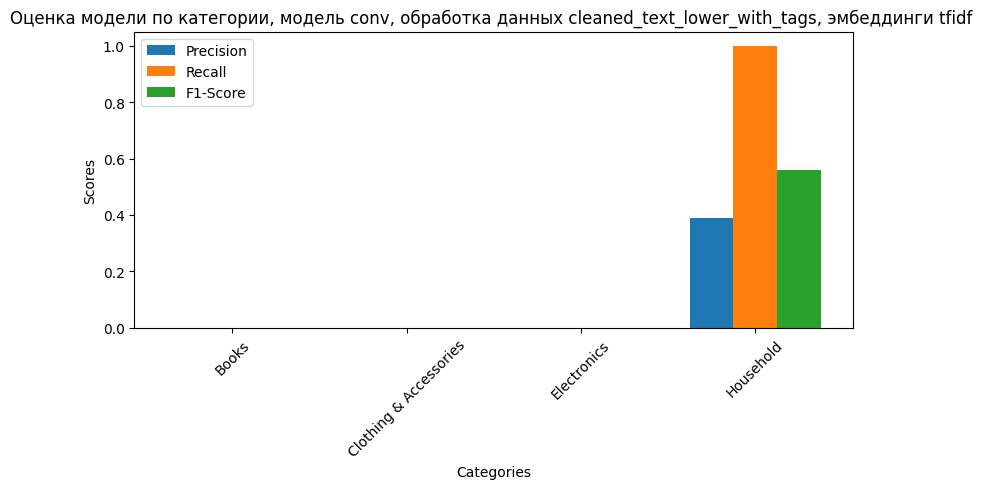

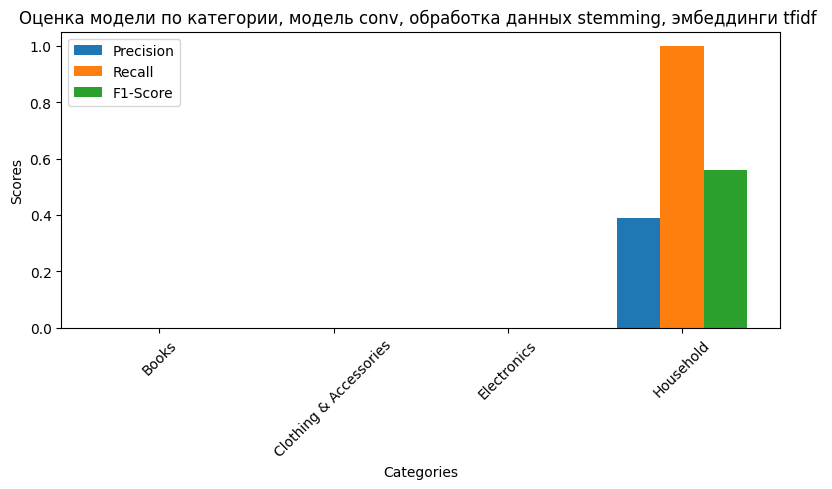

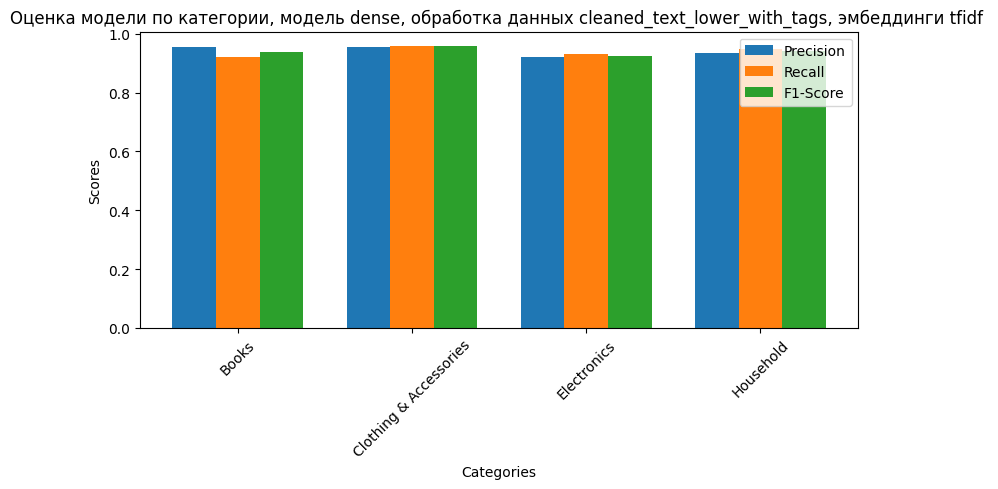

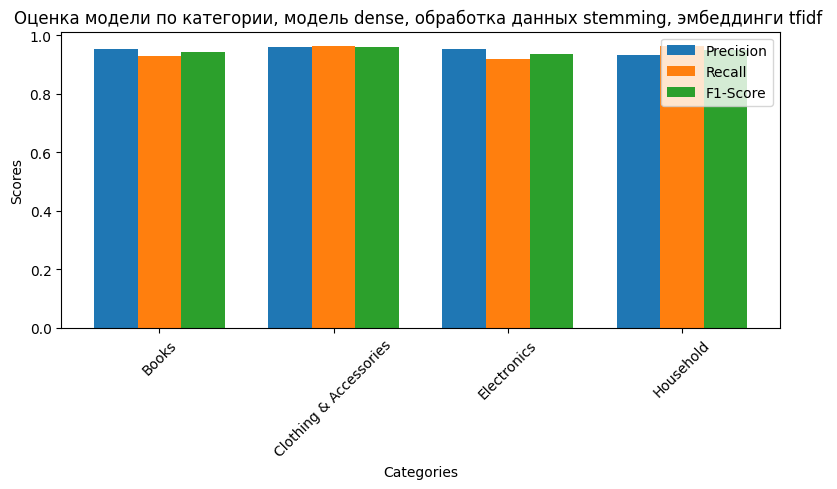

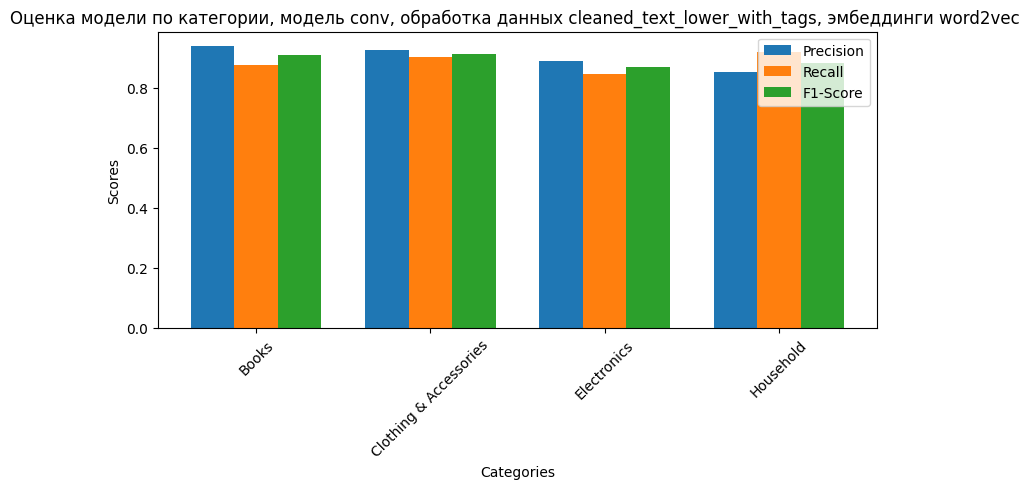

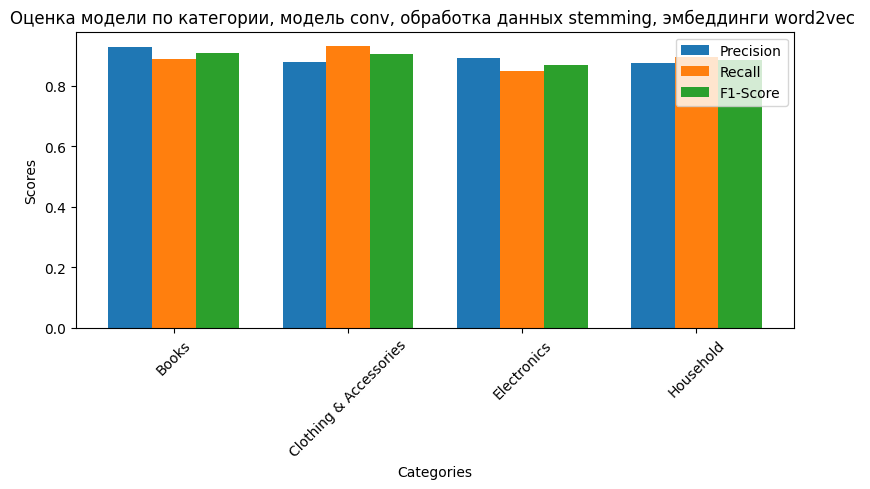

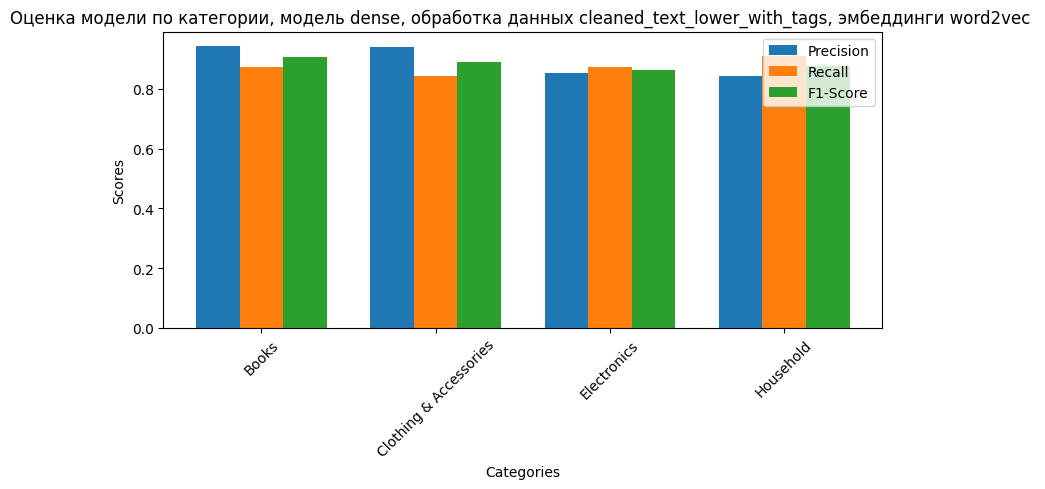

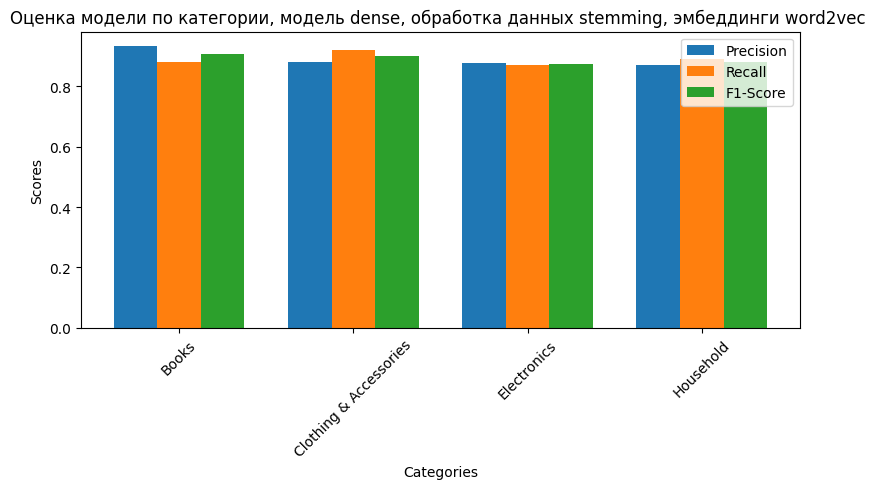

In [ ]:
for source in sources:
    for model_type in model_types:
        for way in ways:
            y_true = neural_models_pred_labels[source][model_type][way][1]
            y_pred = neural_models_pred_labels[source][model_type][way][0]
            plot_classification_metrics(y_true, y_pred, label_encoder.classes_, source, model_type, way)

* По графикам видно, почему в конволюционных слоях на tfidf мы получаем 30% качества - потому что мы научились предсказывать самый многочисленный класс и то на 50% хорошо и на этом все, хахахах
* в модели Dense на tfidf видно, что f1 почти всегда на уровне или выше остальных метрик, что доказывает, качество этой модели + метрики тут более сбалансированны, нет большой разницы
* в остальных случаях f1 меньше precision, что значит, что у нас достаточно высокое качество, но мы довольно часто ошибаемся в принятии решения относительно правильного красса в сторону других

### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, embed_source, model_type, data_preprocess ):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Оценка модели по категории, модель {model_type}, обработка данных {data_preprocess}, эмбеддинги {embed_source} ')

    plt.show()

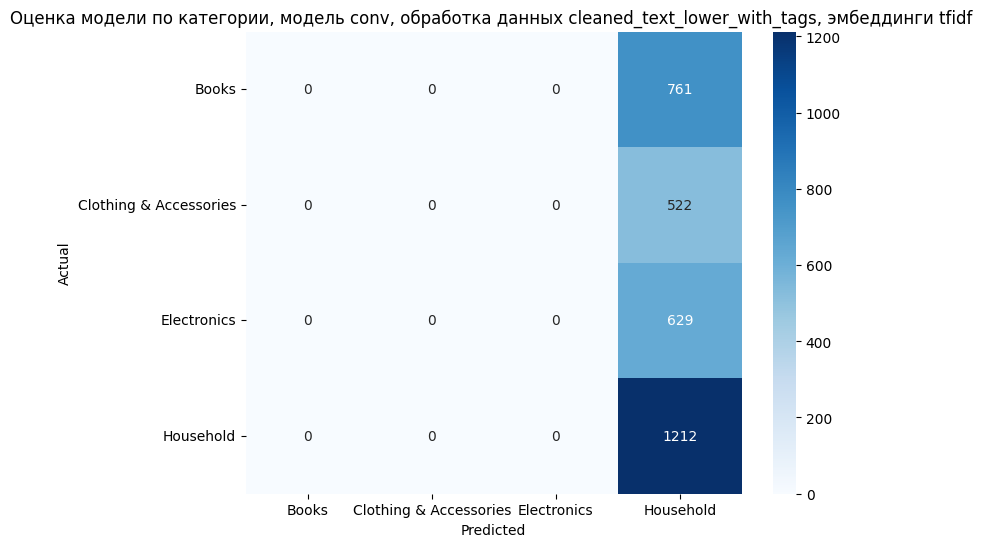

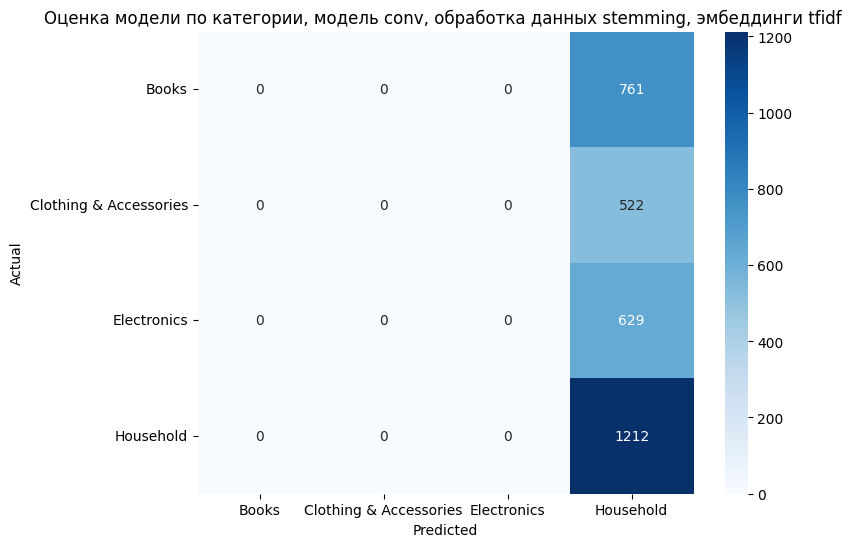

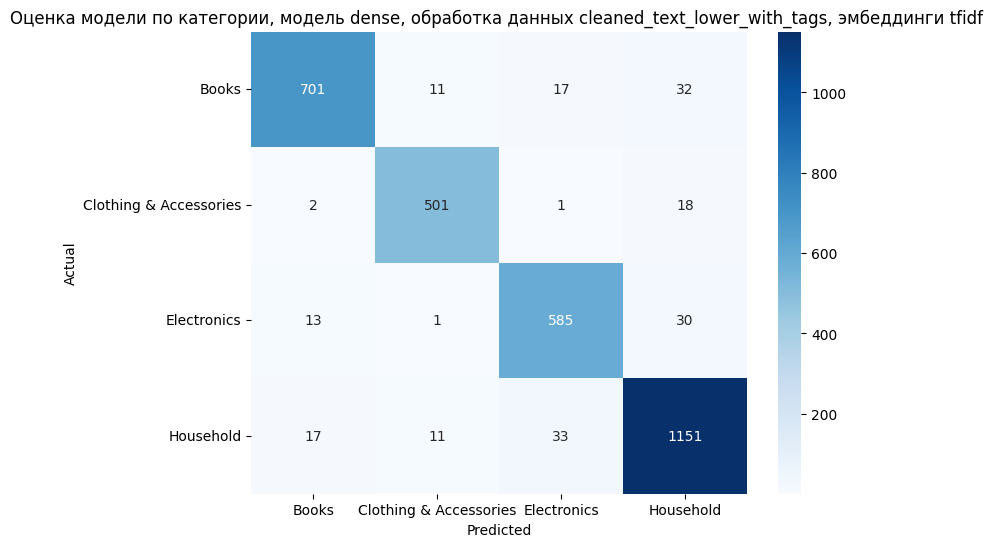

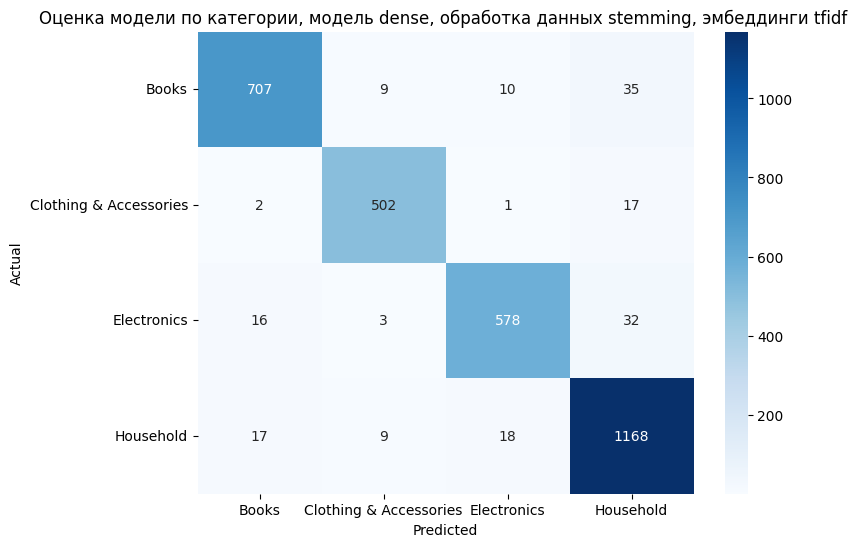

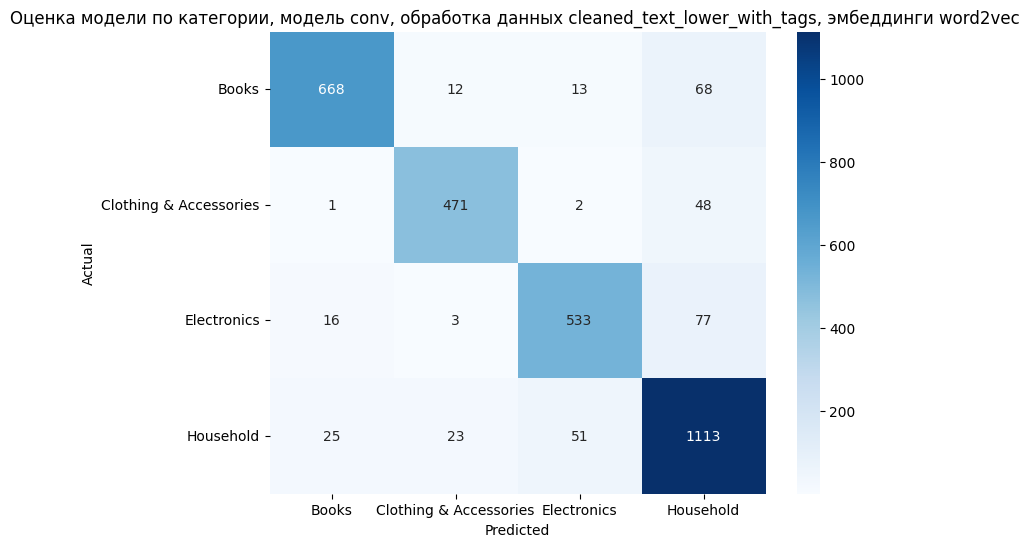

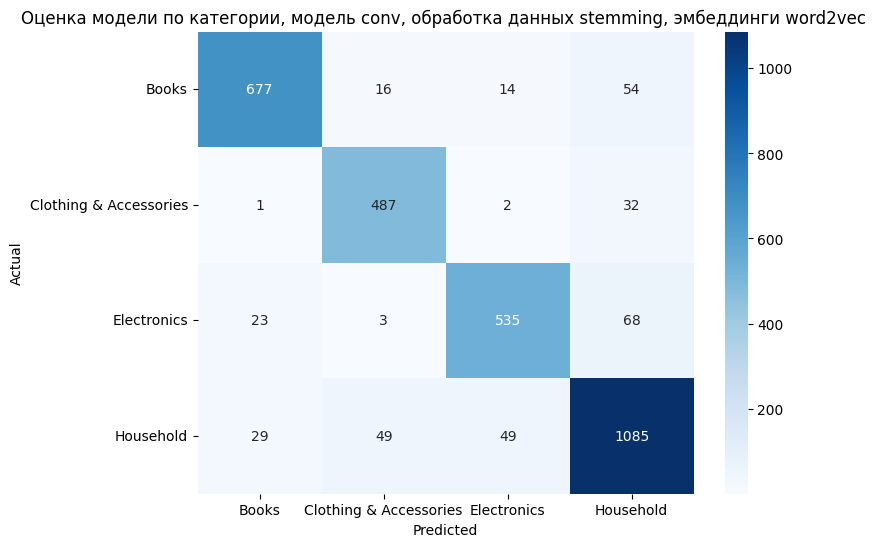

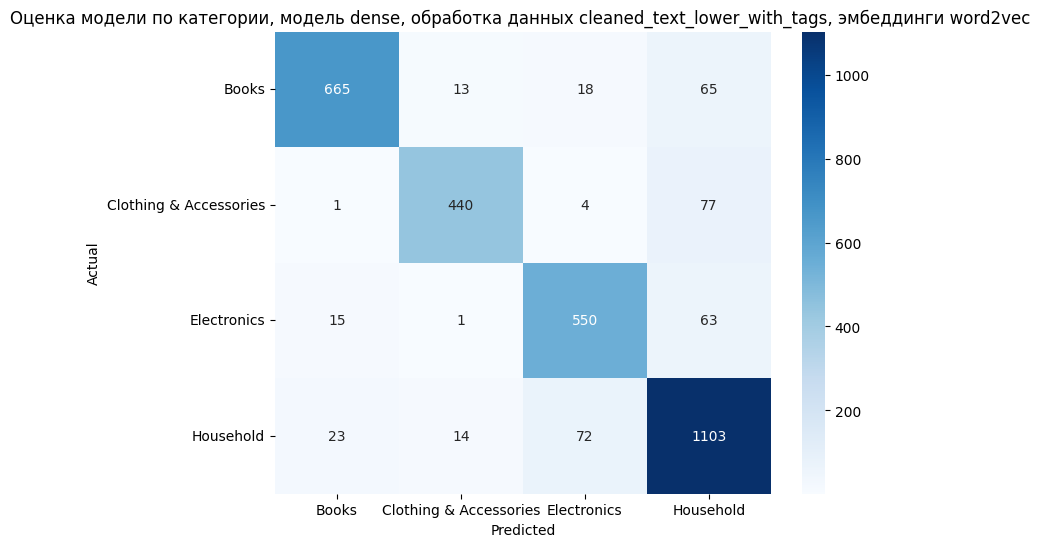

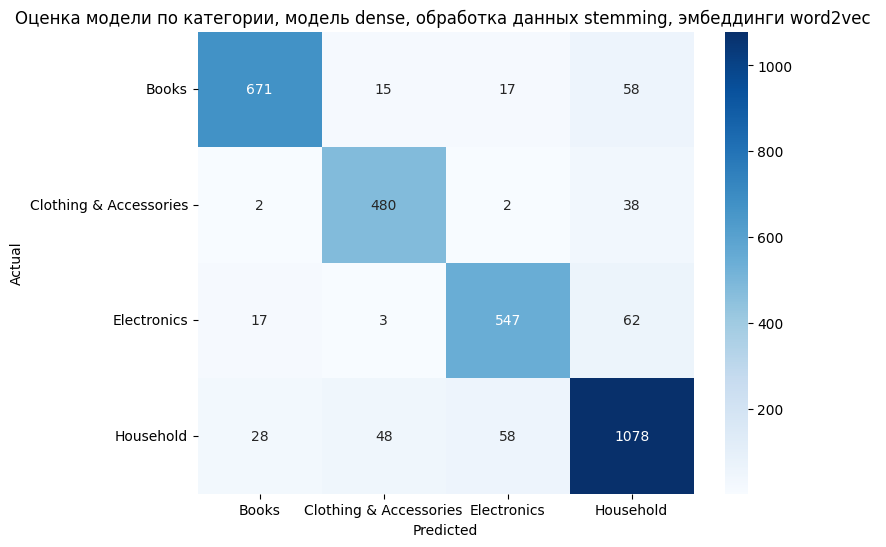

In [ ]:
for source in sources:
    for model_type in model_types:
        for way in ways:
            y_true = neural_models_pred_labels[source][model_type][way][1]
            y_pred = neural_models_pred_labels[source][model_type][way][0]
            plot_confusion_matrix(y_true, y_pred, label_encoder.classes_, source, model_type, way)

Мы понимаем по распределению ошибок первого и второго рода, что в случае с конволюционными слоями на tfidf - все признаки предсказываются как Household и в этом проблема. В остальных способах обучения мы видим четкую диагональ - большинство мы предсказываем правильно, однако наибольшее количество ошибок первого и второго рода приходится на все классы по отношению к Household. Видимо, так как это самый частотный класс - обучаемые модели ставят Household там, где его нет и или другой класс там, где должно быть Household. Возможно это еще потому, что многие темы могут пересекаться с домашними предметами, например техника, но бытовая, книги, но по кулинарии и т.д.

# Большая нейронная модель

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm

class BigBiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(BigBiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm1(embedded)
        lstm_out, _ = self.lstm2(lstm_out)
        pooled = self.dropout(lstm_out[:, -1, :])
        return self.fc(pooled)

def prepare_data_with_indices(texts, tags):
    # Объединяем текст и теги для общего слоя эмбеддингов
    combined_texts = [f"{text} {tag}" for text, tag in zip(texts, tags)]

    text_vectorizer = CountVectorizer(max_features=10000, token_pattern=r'\b\w+\b')
    text_vectorizer.fit(combined_texts)

    X = [torch.tensor([text_vectorizer.vocabulary_.get(word, 0) for word in combined_text.split()], dtype=torch.long)
         for combined_text in combined_texts]
    X_padded = pad_sequence(X, batch_first=True, padding_value=0)

    vocab_size = len(text_vectorizer.vocabulary_)

    return X_padded, vocab_size

def train_big_bilstm_model_with_embeddings(texts, tags, labels, num_classes, embedding_dim=300, hidden_dim=256, batch_size=32, epochs=5, lr = 0.001):
    X_padded, vocab_size = prepare_data_with_indices(texts, tags)
    y_tensor = torch.tensor(labels, dtype=torch.long)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_data = TensorDataset(X_padded, y_tensor)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    model = BigBiLSTMModel(vocab_size, embedding_dim, hidden_dim, num_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in tqdm(range(epochs)):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
        losses.append(loss.item())
    return model, losses

# Функция для предсказания и вычисления accuracy
def evaluate_big_bilstm_model(model, texts, tags, labels, batch_size=32):
    X_padded, _ = prepare_data_with_indices(texts, tags)
    y_tensor = torch.tensor(labels, dtype=torch.long)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    correct = 0

    eval_data = TensorDataset(X_padded, y_tensor)
    eval_loader = DataLoader(eval_data, batch_size=batch_size, shuffle=False)

    y_pred = []
    y_true = []

    with torch.no_grad():
        for X_batch, y_batch in eval_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            # print(outputs)
            _, predicted = torch.max(outputs, 1)
            # print(predicted)
            correct += (predicted == y_batch).sum().item()
            y_pred.extend(predicted.cpu().tolist())
            y_true.extend(y_batch.cpu().tolist())

    accuracy = correct / len(labels)
    print(f"Accuracy: {accuracy:.4f}")

    return y_pred, y_true

## start run

In [ ]:
lstm_models = []

In [ ]:
models = {}

models["embedding_dim"] = 1000
models["hidden_dim"] = 256
models["epochs"] = 15
models["source"] = "cleaned_text_lower"
models["model"], models["loses"] = train_big_bilstm_model_with_embeddings(X_train["cleaned_text_lower"], X_train["tags"], y_train, num_classes = 4, embedding_dim=models["embedding_dim"], hidden_dim=models["hidden_dim"], batch_size=32, epochs=models["epochs"])


lstm_models.append(models)

  7%|▋         | 1/15 [00:30<07:00, 30.02s/it]

Epoch 1/15, Loss: 1.3015


 13%|█▎        | 2/15 [00:59<06:29, 29.93s/it]

Epoch 2/15, Loss: 1.3706


 20%|██        | 3/15 [01:29<05:59, 29.97s/it]

Epoch 3/15, Loss: 1.1621


 27%|██▋       | 4/15 [01:59<05:27, 29.78s/it]

Epoch 4/15, Loss: 1.4666


 33%|███▎      | 5/15 [02:29<04:57, 29.73s/it]

Epoch 5/15, Loss: 1.3439


 40%|████      | 6/15 [02:59<04:28, 29.83s/it]

Epoch 6/15, Loss: 1.3142


 47%|████▋     | 7/15 [03:29<03:59, 29.89s/it]

Epoch 7/15, Loss: 1.3922


 53%|█████▎    | 8/15 [03:59<03:29, 29.93s/it]

Epoch 8/15, Loss: 1.5966


 60%|██████    | 9/15 [04:29<02:59, 29.94s/it]

Epoch 9/15, Loss: 1.5394


 67%|██████▋   | 10/15 [04:59<02:29, 29.96s/it]

Epoch 10/15, Loss: 1.4151


 73%|███████▎  | 11/15 [05:29<01:59, 29.97s/it]

Epoch 11/15, Loss: 1.2016


 80%|████████  | 12/15 [05:59<01:29, 29.98s/it]

Epoch 12/15, Loss: 1.3362


 87%|████████▋ | 13/15 [06:29<00:59, 29.98s/it]

Epoch 13/15, Loss: 1.2687


 93%|█████████▎| 14/15 [06:58<00:29, 29.94s/it]

Epoch 14/15, Loss: 1.3828


100%|██████████| 15/15 [07:28<00:00, 29.92s/it]

Epoch 15/15, Loss: 1.4756


In [ ]:
lstm_models[0]["pred"],lstm_models[0]["true"]  = evaluate_big_bilstm_model(lstm_models[0]["model"], X_test["cleaned_text_lower"], X_test["tags"], y_test)

Accuracy: 0.3880


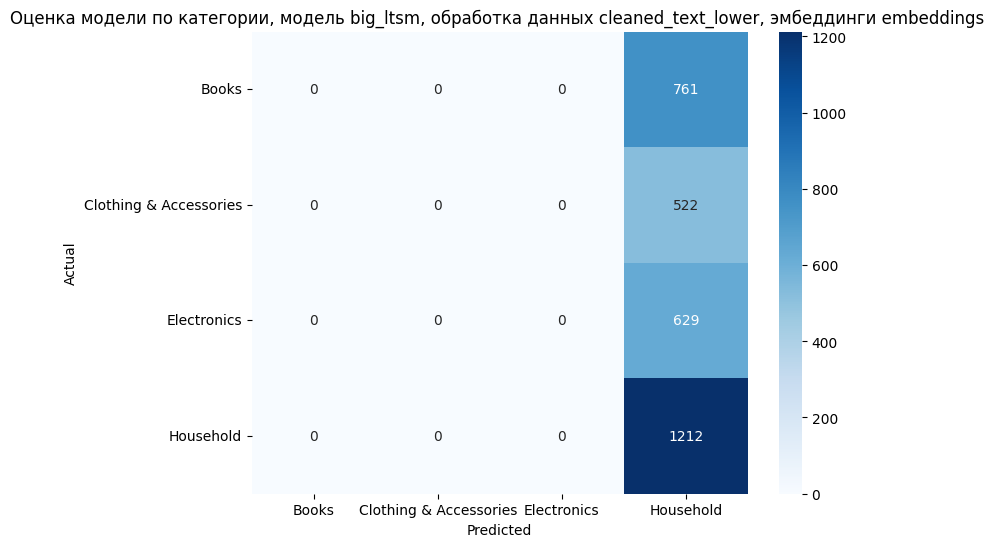

In [ ]:
plot_confusion_matrix(lstm_models[0]["true"], lstm_models[0]["pred"], label_encoder.classes_, "embeddings", "big_ltsm", lstm_models[0]["source"])

Видно, что нашей стартовой моделью и стартовыми гиперпараметрами мы предсказываем только один класс - Household и все остальные подгоняем под него. Попробуем поменять гиперпараметры, и в частности расширить скрытую размерность.

## расширение hidden_dim

In [ ]:
models = {}

models["embedding_dim"] = 1000
models["hidden_dim"] = 512
models["epochs"] = 15
models["source"] = "cleaned_text_lower"

models["model"], models["loses"] = train_big_bilstm_model_with_embeddings(X_train["cleaned_text_lower"], X_train["tags"], y_train, num_classes = 4, embedding_dim=models["embedding_dim"], hidden_dim=models["hidden_dim"], batch_size=32, epochs=models["epochs"])

lstm_models.append(models)

  7%|▋         | 1/15 [00:34<08:09, 34.99s/it]

Epoch 1/15, Loss: 1.6335


 13%|█▎        | 2/15 [01:10<07:35, 35.08s/it]

Epoch 2/15, Loss: 1.4364


 20%|██        | 3/15 [01:45<07:01, 35.12s/it]

Epoch 3/15, Loss: 1.2587


 27%|██▋       | 4/15 [02:20<06:26, 35.17s/it]

Epoch 4/15, Loss: 1.4597


 33%|███▎      | 5/15 [02:55<05:51, 35.15s/it]

Epoch 5/15, Loss: 1.3924


 40%|████      | 6/15 [03:30<05:16, 35.13s/it]

Epoch 6/15, Loss: 1.3907


 47%|████▋     | 7/15 [04:05<04:41, 35.17s/it]

Epoch 7/15, Loss: 1.4218


 53%|█████▎    | 8/15 [04:41<04:06, 35.17s/it]

Epoch 8/15, Loss: 1.4386


 60%|██████    | 9/15 [05:16<03:31, 35.21s/it]

Epoch 9/15, Loss: 1.1701


 67%|██████▋   | 10/15 [05:51<02:56, 35.27s/it]

Epoch 10/15, Loss: 1.3084


 73%|███████▎  | 11/15 [06:27<02:21, 35.28s/it]

Epoch 11/15, Loss: 1.3691


 80%|████████  | 12/15 [07:02<01:45, 35.28s/it]

Epoch 12/15, Loss: 1.7129


 87%|████████▋ | 13/15 [07:37<01:10, 35.28s/it]

Epoch 13/15, Loss: 1.2006


 93%|█████████▎| 14/15 [08:13<00:35, 35.28s/it]

Epoch 14/15, Loss: 1.3917


100%|██████████| 15/15 [08:48<00:00, 35.22s/it]

Epoch 15/15, Loss: 1.4695


In [ ]:
lstm_models[1]["pred"],lstm_models[1]["true"]  = evaluate_big_bilstm_model(lstm_models[1]["model"], X_test["cleaned_text_lower"], X_test["tags"], y_test)

Accuracy: 0.3880


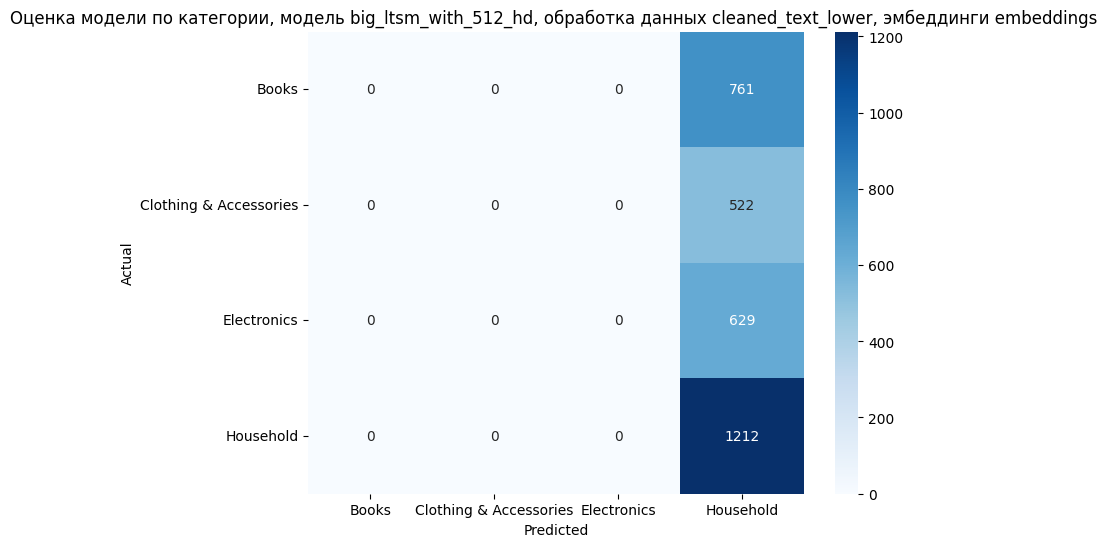

In [ ]:
plot_confusion_matrix(lstm_models[1]["true"], lstm_models[1]["pred"], label_encoder.classes_, "embeddings", "big_ltsm_with_512_hd", lstm_models[1]["source"])

не помогло, давайте попробуем увеличит пространство эмбеддингов, возможно нам недостаточно "семантики" от эмбеддингов

## расширение embedding_dim

In [ ]:
models = {}

models["embedding_dim"] = 10000
models["hidden_dim"] = 256
models["epochs"] = 15
models["source"] = "cleaned_text_lower"

models["model"], models["loses"] = train_big_bilstm_model_with_embeddings(X_train["cleaned_text_lower"], X_train["tags"], y_train, num_classes = 4, embedding_dim=models["embedding_dim"], hidden_dim=models["hidden_dim"], batch_size=32, epochs=models["epochs"])

lstm_models.append(models)

  7%|▋         | 1/15 [00:45<10:36, 45.46s/it]

Epoch 1/15, Loss: 1.2169


 13%|█▎        | 2/15 [01:30<09:51, 45.48s/it]

Epoch 2/15, Loss: 1.1749


 20%|██        | 3/15 [02:16<09:04, 45.42s/it]

Epoch 3/15, Loss: 1.3873


 27%|██▋       | 4/15 [03:01<08:18, 45.35s/it]

Epoch 4/15, Loss: 1.5440


 33%|███▎      | 5/15 [03:46<07:33, 45.36s/it]

Epoch 5/15, Loss: 0.8542


 40%|████      | 6/15 [04:32<06:48, 45.42s/it]

Epoch 6/15, Loss: 0.9324


 47%|████▋     | 7/15 [05:18<06:03, 45.48s/it]

Epoch 7/15, Loss: 0.7045


 53%|█████▎    | 8/15 [06:03<05:18, 45.54s/it]

Epoch 8/15, Loss: 0.9676


 60%|██████    | 9/15 [06:49<04:33, 45.57s/it]

Epoch 9/15, Loss: 1.5448


 67%|██████▋   | 10/15 [07:35<03:48, 45.61s/it]

Epoch 10/15, Loss: 0.6391


 73%|███████▎  | 11/15 [08:20<03:01, 45.44s/it]

Epoch 11/15, Loss: 1.1280


 80%|████████  | 12/15 [09:04<02:15, 45.14s/it]

Epoch 12/15, Loss: 0.9114


 87%|████████▋ | 13/15 [09:48<01:29, 44.92s/it]

Epoch 13/15, Loss: 0.9717


 93%|█████████▎| 14/15 [10:33<00:44, 44.92s/it]

Epoch 14/15, Loss: 0.7368


100%|██████████| 15/15 [11:19<00:00, 45.27s/it]

Epoch 15/15, Loss: 0.7198


In [ ]:
lstm_models[2]["pred"],lstm_models[2]["true"]  = evaluate_big_bilstm_model(lstm_models[2]["model"], X_test["cleaned_text_lower"], X_test["tags"], y_test)

Accuracy: 0.3473


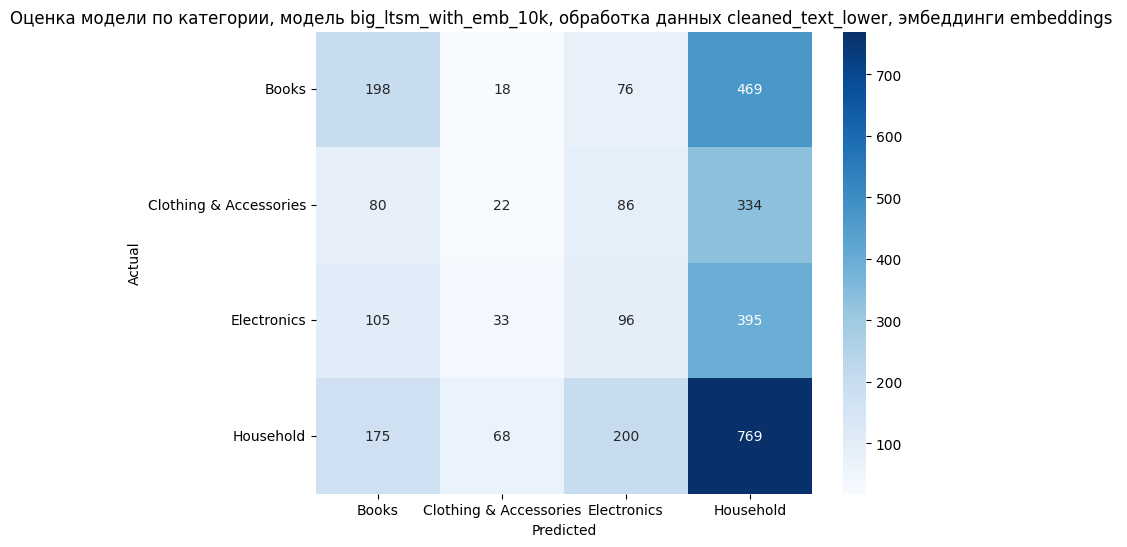

In [ ]:
plot_confusion_matrix(lstm_models[2]["true"], lstm_models[2]["pred"], label_encoder.classes_, "embeddings", "big_ltsm_with_emb_10k", lstm_models[2]["source"])

Ооо, какой-то движ пошел, хоть и качество упало=( либо мы уже успели переучиться, что не видно по лоссу, то ли мы недоучились.

## добавление layer norm и еще два слоя lstm

In [ ]:
class BigBiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(BigBiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=2)
        self.norm = nn.LayerNorm(hidden_dim * 2)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True, num_layers=2)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm1(embedded)
        lstm_out = self.norm(lstm_out)  # Добавлена нормализация
        lstm_out, _ = self.lstm2(lstm_out)
        pooled = self.dropout(lstm_out[:, -1, :])
        return self.fc(pooled)

In [ ]:
models = {}

models["embedding_dim"] = 10000
models["hidden_dim"] = 512
models["epochs"] = 15
models["source"] = "cleaned_text_lower"

models["model"], models["loses"] = train_big_bilstm_model_with_embeddings(X_train["cleaned_text_lower"], X_train["tags"], y_train, num_classes = 4, embedding_dim=models["embedding_dim"], hidden_dim=models["hidden_dim"], batch_size=32, epochs=models["epochs"])

lstm_models.append(models)

  7%|▋         | 1/15 [01:41<23:45, 101.80s/it]

Epoch 1/15, Loss: 1.1042


 13%|█▎        | 2/15 [03:22<21:54, 101.09s/it]

Epoch 2/15, Loss: 1.0320


 20%|██        | 3/15 [05:02<20:09, 100.80s/it]

Epoch 3/15, Loss: 1.3147


 27%|██▋       | 4/15 [06:43<18:26, 100.58s/it]

Epoch 4/15, Loss: 1.4184


 33%|███▎      | 5/15 [08:23<16:44, 100.50s/it]

Epoch 5/15, Loss: 1.4392


 40%|████      | 6/15 [10:03<15:04, 100.49s/it]

Epoch 6/15, Loss: 1.3575


 47%|████▋     | 7/15 [11:45<13:26, 100.75s/it]

Epoch 7/15, Loss: 1.0470


 53%|█████▎    | 8/15 [13:26<11:46, 100.96s/it]

Epoch 8/15, Loss: 1.3539


 60%|██████    | 9/15 [15:07<10:06, 101.08s/it]

Epoch 9/15, Loss: 1.1327


 67%|██████▋   | 10/15 [16:49<08:26, 101.34s/it]

Epoch 10/15, Loss: 1.5924


 73%|███████▎  | 11/15 [18:31<06:45, 101.43s/it]

Epoch 11/15, Loss: 1.2554


 80%|████████  | 12/15 [20:13<05:04, 101.51s/it]

Epoch 12/15, Loss: 1.5272


 87%|████████▋ | 13/15 [21:54<03:23, 101.55s/it]

Epoch 13/15, Loss: 1.3397


 93%|█████████▎| 14/15 [23:35<01:41, 101.37s/it]

Epoch 14/15, Loss: 0.7090


100%|██████████| 15/15 [25:16<00:00, 101.10s/it]

Epoch 15/15, Loss: 1.2576


In [ ]:
ind = 3
lstm_models[ind]["pred"],lstm_models[ind]["true"]  = evaluate_big_bilstm_model(lstm_models[ind]["model"], X_test["cleaned_text_lower"], X_test["tags"], y_test)

Accuracy: 0.2810


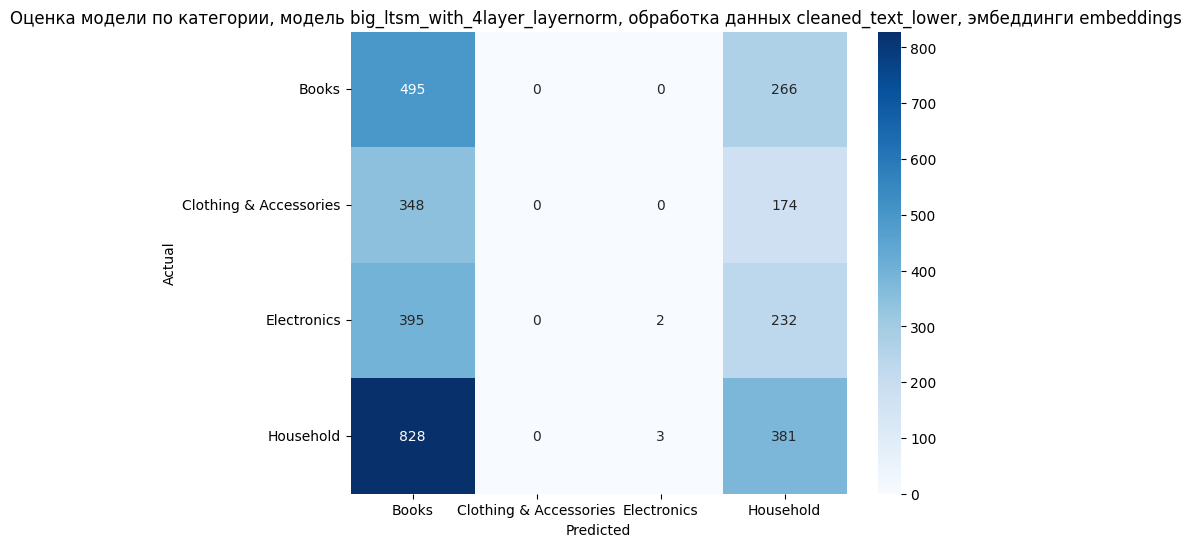

In [ ]:
plot_confusion_matrix(lstm_models[ind]["true"], lstm_models[ind]["pred"], label_encoder.classes_, "embeddings", "big_ltsm_with_4layer_layernorm", lstm_models[ind]["source"])

Как можно заметить, теперь нам нравится другой класс - Books)))) видимо добавление еще большего количества слоев смещает модель в сторону какого-то класса.

## добавим Dense слои

In [ ]:
class BigBiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(BigBiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        # Добавляем несколько полносвязных слоев
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm1(embedded)
        lstm_out, _ = self.lstm2(lstm_out)

        pooled = self.dropout(lstm_out[:, -1, :])

        # Проходим через полносвязные слои
        dense_out = torch.relu(self.fc1(pooled))
        output = self.fc2(dense_out)

        return output

In [ ]:
models = {}

models["embedding_dim"] = 10000
models["hidden_dim"] = 512
models["epochs"] = 8
models["source"] = "cleaned_text_lower"

models["model"], models["loses"] = train_big_bilstm_model_with_embeddings(X_train["cleaned_text_lower"], X_train["tags"], y_train, num_classes = 4, embedding_dim=models["embedding_dim"], hidden_dim=models["hidden_dim"], batch_size=32, epochs=models["epochs"])

lstm_models.append(models)
ind = 4
lstm_models[ind]["pred"], lstm_models[ind]["true"]  = evaluate_big_bilstm_model(lstm_models[ind]["model"], X_test["cleaned_text_lower"], X_test["tags"], y_test)

 25%|██▌       | 1/4 [01:05<03:15, 65.13s/it]

Epoch 1/4, Loss: 1.4348


 50%|█████     | 2/4 [02:10<02:10, 65.19s/it]

Epoch 2/4, Loss: 1.4730


 75%|███████▌  | 3/4 [03:15<01:05, 65.04s/it]

Epoch 3/4, Loss: 1.1807


100%|██████████| 4/4 [04:20<00:00, 65.09s/it]

Epoch 4/4, Loss: 1.2552


Accuracy: 0.3880


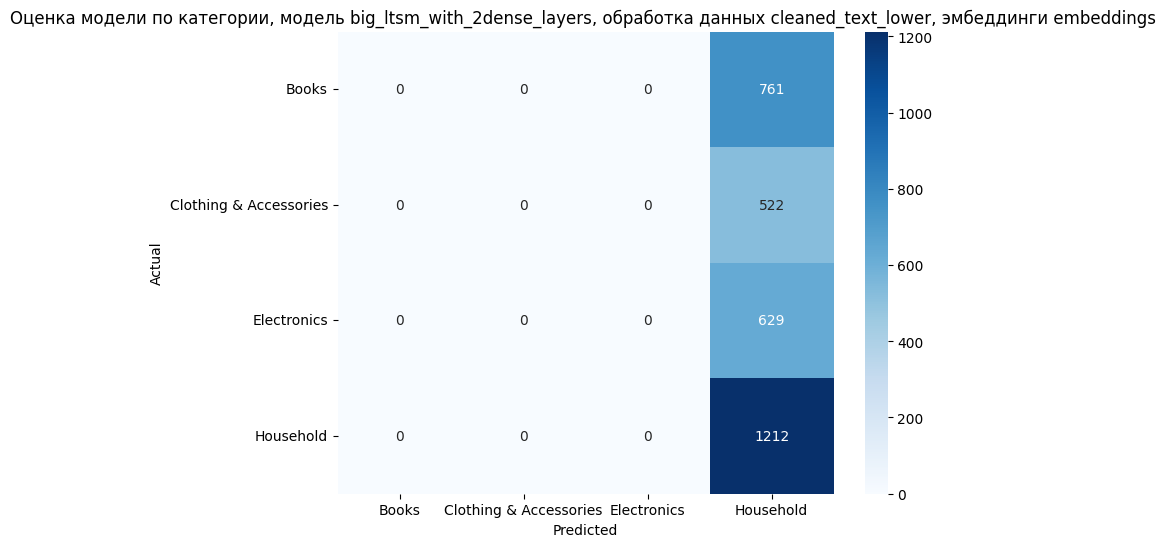

In [ ]:
plot_confusion_matrix(lstm_models[ind]["true"], lstm_models[ind]["pred"], label_encoder.classes_, "embeddings", "big_ltsm_with_2dense_layers", lstm_models[ind]["source"])

В общем не помогло....=(

Очевидный вопрос, почему так? Ответом на него является то, что в целом, наши данные не имеют сильно долгосрочных зависимостей, а еще с помощью простых способов типа поиска самых популярных слов -  данные хорошо сепарируются. Поэтому в данном случае, сложное - враг простого. Можно использовать 2 слойную dense сетку на Word2vec и радоваться жизни.

Вопрос: зачем нам тогда LSTM, если и плотные слои справляются хорошо сами по себе? Если мы можем дать лучшее решение - меньшим количеством ресурсов - то это супер хорошо для бизнес реалий. Поэтому в данном случае остановимся на 2DenseNet как на лучшем решении, показывающем на TF-IDF векторах при стемминге или при простой очистке данных с тегами качество 94-95% на тренировочном тесте.